# Importing Libraries

In [1]:
#from matplotlib.ticker import FuncFormatter
from pandas.io.json import json_normalize
from urllib.request import urlopen,Request
import time
import PIL.Image
from IPython.display import Image
from os import path
import json
#import locale
import matplotlib
import matplotlib.pyplot as plt
import os
import pandas as pd
import requests
import sqlalchemy
import sqlite3
import csv
#%matplotlib inline
#import matplotlib.pyplot as plt
from IPython.display import Image, HTML
import datetime
#import ast
import seaborn as sns
import numpy as np
#from scipy import stats
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import train_test_split
#from xgboost import XGBClassifier, XGBRegressor
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import plotly
import plotly.plotly as py
plotly.tools.set_credentials_file(username='KonradBorowiec', api_key='xTMcQX56nKbYbDAcPJp6')
#https://plot.ly/python/getting-started/

sns.set_style('whitegrid')
sns.set(font_scale=1.25)
pd.set_option('display.max_colwidth', 50)

# Collecting data

## Movies

### Documentation: https://developers.themoviedb.org/3/movies/get-movie-details

### Description of fields:

- **budget**:
    - budget of the movie expressed in dollars
- **id**:
    - movie ID assigned by themoviedb.org
- **imdb_id**:
    - IMDB ID of the movie
- **original_language**:
    - language in which the movie was originally directed
- **original_title**:
    - original title of the movie
- **overview**:
    - a brief description of the movie
- **popularity**:
    - popularity score calculated by themoviedb.org
- **poster_path**:
     - URL of the poster image
- **release_date**:
    - release date of the movie
- **revenue**:
    - revenue of the movie expressed in dollars
- **runtime**:
    - runtime of the movie in minutes
- **status**:
    - status of the movie
- **title**:
    - official title of the movie
- **vote_average**:
     - average rating of the movie calculated by themoviedb.org
- **vote_count**:
     - number of votes by users calculated by themoviedb.org

In [12]:
def movies(directory, headers, api_key, stop, start, writing_mode):
    
    if not os.path.exists(directory):
        os.makedirs(directory)
        os.chdir(directory)
    else:
        os.chdir(directory)
    print(os.getcwd())
        
    while start < stop:
        response = requests.get('https://api.themoviedb.org/3/movie/' + str(start) + '?api_key=' + api_key)
        data = response.json()
        filtered_data = {k : v for k, v in filter(lambda t: t[0] in headers, data.items())}
        df = pd.DataFrame(filtered_data, index = [0])
                 
        with open('movies.csv', str(writing_mode)) as f:
            df.to_csv(f, header = False, sep = ',', encoding = 'utf-8')
        print(start)
        start += 1
        
    header_to_pass = ["idx"] + headers
    
    df = pd.read_csv(directory + 'movies.csv', header = None, names = header_to_pass, error_bad_lines = False)
    df.rename(columns={0: header_to_pass[0], 1: header_to_pass[1], 2: header_to_pass[2], 3: header_to_pass[3], 4: header_to_pass[4], 5: header_to_pass[5], 6: header_to_pass[6], 7: header_to_pass[7], 8: header_to_pass[8], 9: header_to_pass[9], 10: header_to_pass[10], 11: header_to_pass[11], 12: header_to_pass[12], 13: header_to_pass[13], 14: header_to_pass[14], 15: header_to_pass[15]}, inplace=True)
    df.to_csv(directory + '/backup/movies.csv', index = False)

    with open(directory + '/backup/movies.csv', 'r') as table:
        dr = csv.DictReader(table, delimiter = ',')
        to_db = [(i[header_to_pass[0]], i[header_to_pass[1]], i[header_to_pass[2]], i[header_to_pass[3]], i[header_to_pass[4]] , i[header_to_pass[5]], i[header_to_pass[6]], i[header_to_pass[7]], i[header_to_pass[8]], i[header_to_pass[9]], i[header_to_pass[10]], i[header_to_pass[11]], i[header_to_pass[12]], i[header_to_pass[13]], i[header_to_pass[14]], i[header_to_pass[15]] ) for i in dr]

        
    con = sqlite3.connect(directory + 'movies.sqlite')
    cursor = con.cursor()
    
    cursor.execute('''
    DROP TABLE IF EXISTS movies
    ''')
    con.commit()
    
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS movies(idx STR, budget INT, id STR, imdb_id STR, original_language STR, original_title STR, overview STR,
                  popularity FLOAT, poster_path STR, release_date DATE, revenue FLOAT, runtime INT, status STR, title STR, vote_average FLOAT, vote_count INT)
    ''')
    con.commit()
    
    cursor.executemany("INSERT INTO movies VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?);", to_db)
    con.commit()
    con.close()


directory = '/home/konrad/movies/'
headers = ["budget", "id","imdb_id", "original_language", "original_title", "overview", "popularity", "poster_path", "release_date","revenue","runtime","status","title","vote_average","vote_count"]
api_key = 'e4f5b3b79e2ab374455c1c1e1d0ca014'
stop = 72501
start = 72500
writing_mode = 'a'

movies(directory, headers, api_key, stop, start, writing_mode)

/home/konrad/movies
72500


## Genres

### Documentation: https://developers.themoviedb.org/3/movies/get-movie-details

### Description of fields:

- **id**:
    - ID of the genre
- **name**:
    - genre name
- **imdb_id**:
    - IMDB ID of the movie

In [13]:
def genres(directory, headers, api_key, stop, start, writing_mode):
    
    if not os.path.exists(directory):
        os.makedirs(directory)
        os.chdir(directory)
    else:
        os.chdir(directory)
    print(os.getcwd())
        
    while start < stop:
        response = requests.get('https://api.themoviedb.org/3/movie/' + str(start) +'?api_key=' +  api_key)
        data = response.json()
        
        if 'The resource you requested could not be found.' in data.values():
            start += 1
            
        else:            
            data_normalized = json_normalize(data, "genres", ["imdb_id"])
            df = pd.DataFrame(data_normalized, index = [0])
            
            with open('genres.csv', str(writing_mode)) as f:
                df.to_csv(f, header = False, sep = ',', encoding = 'utf-8')
            print(start)
            
        start += 1

    header_to_pass = ["idx"] + headers

    df = pd.read_csv(directory + 'genres.csv', header=None, names=header_to_pass, error_bad_lines=False)
    df.rename(columns={0: header_to_pass[0], 1: header_to_pass[1], 2: header_to_pass[2], 3: header_to_pass[3]}, inplace=True)
    df.to_csv(directory + '/backup/genres.csv', index=False)

    with open(directory + '/backup/genres.csv', 'r') as table:
        dr = csv.DictReader(table, delimiter=',')
        to_db = [(i[header_to_pass[0]], i[header_to_pass[1]], i[header_to_pass[2]], i[header_to_pass[3]]) for i in dr]

    
    con = sqlite3.connect(directory + 'movies.sqlite')
    cursor = con.cursor()
    
    cursor.execute('''
    DROP TABLE IF EXISTS genres
    ''')
    con.commit()

    cursor.execute('''
    CREATE TABLE IF NOT EXISTS genres(idx STR, id STR, name STR, imdb_id STR)
    ''')
    con.commit()

    cursor.executemany("INSERT INTO genres VALUES (?,?,?,?);", to_db)
    con.commit()
    con.close()
    

    
directory = '/home/konrad/movies/'
headers = ["id", "name", "imdb_id"]
api_key = '69d2d11ea34cd0ff95c454c73786a6a7'
stop = 72501
start = 72500
writing_mode = 'a'

genres(directory, headers, api_key, stop, start, writing_mode)

/home/konrad/movies
72500


## Production Countries

### Documentation: https://developers.themoviedb.org/3/movies/get-movie-details

### Description of fields:

- **iso_3166_1**:
    - ID of country
- **name**:
    - country name
- **imdb_id**:
    - IMDB ID of the movie

In [24]:
def productionCountries(directory, headers, api_key, stop, start, writing_mode):

    if not os.path.exists(directory):
        os.makedirs(directory)
        os.chdir(directory)
    else:
        os.chdir(directory)
    print(os.getcwd())
        
    while start < stop:
        response = requests.get('https://api.themoviedb.org/3/movie/'+ str(start) +'?api_key='+  api_key)
        data = response.json()
        
        if 'The resource you requested could not be found.' in data.values():
            start += 1
            
        else:
            data_normalized = json_normalize(data,"production_countries",["imdb_id"])
            df = pd.DataFrame(data_normalized, index = [0])

            with open('productioncountries.csv', str(writing_mode)) as f:
                df.to_csv(f, header = False, sep = ',', encoding = 'utf-8')
            print(start)
        
        start += 1

    df = pd.read_csv(directory + '/productioncountries.csv', header = None, names = headers, error_bad_lines = False)
    df.rename(columns={0: headers[0], 1: headers[1], 2: headers[2]}, inplace = True)
    df.to_csv(directory + 'backup/productioncountries.csv', index = False)

    with open(directory + '/backup/productioncountries.csv', 'r') as table:
        dr = csv.DictReader(table, delimiter = ',')
        to_db = [(i[headers[0]], i[headers[1]], i[headers[2]]) for i in dr]

    
    con = sqlite3.connect(directory + 'movies.sqlite')
    cursor = con.cursor()
    
    cursor.execute('''
    DROP TABLE IF EXISTS productioncountries
    ''')
    con.commit()
    
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS productioncountries(iso_3166_1 STR, name STR, imdb_id STR)
    ''')
    con.commit()
    
    cursor.executemany("INSERT INTO productioncountries VALUES (?,?,?);", to_db)
    con.commit()
    con.close()

directory = '/home/konrad/movies/'
headers = ["iso_3166_1", "name", "imdb_id"]
api_key = 'ab9bd0e209dd5c8bf42b028a63bc4e29'
stop = 199710
start = 199709
writing_mode = 'a'

productionCountries(directory, headers, api_key, stop, start, writing_mode)

/home/konrad/movies
199704
199705
199708
199709


##  Keywords

### Documentation: https://developers.themoviedb.org/3/movies/get-movie-keywords

### Description of fields:

- **keywords**:
    - tags used to describe a movie
- **id**:
    - movie ID assigned by themoviedb.org

In [2]:
def keywords(directory, headers, api_key, stop, start, writing_mode):

    if not os.path.exists(directory):
        os.makedirs(directory)
        os.chdir(directory)
    else:
        os.chdir(directory)
    print(os.getcwd())
    
    con = sqlite3.connect(directory + 'movies.sqlite')
    cursor = con.cursor()
          
    df = pd.read_sql_query("SELECT imdb_id FROM (SELECT DISTINCT imdb_id FROM movies) WHERE imdb_id <> ''", con)
    l = df['imdb_id'].tolist()
    editedList = l[start:stop]

    for i in editedList:
        response = requests.get("https://api.themoviedb.org/3/movie/" + i + "/keywords?api_key=" + api_key)
        data = response.json()
        data_normalized = json_normalize(data, "keywords", ["id"], meta_prefix = "Movie.")
        df = pd.DataFrame(data_normalized)

        with open(directory + 'keywords.csv', str(writing_mode)) as f:
            df.to_csv(f, header = False, sep = ',', encoding = 'utf-8')
        print(start) 
        start += 1
        
    header_to_pass = ["idx"] + headers
    
    df = pd.read_csv(directory + 'keywords.csv', header = None, names = header_to_pass, error_bad_lines = False)
    df.rename(columns={0: header_to_pass[0], 1: header_to_pass[1], 2: header_to_pass[2]}, inplace = True)
    df.to_csv(directory + '/backup/keywords.csv', index = False)

    with open(directory + '/backup/keywords.csv','r') as table:
        dr = csv.DictReader(table, delimiter = ',')
        to_db = [(i[header_to_pass[0]], i[header_to_pass[1]], i[header_to_pass[2]]) for i in dr]
        
    
    cursor.execute('''
        DROP TABLE IF EXISTS keywords
    ''')
    con.commit()
    
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS keywords(idx STR, keywords STR, id STR)
    ''')
    con.commit()
    
    cursor.executemany("INSERT INTO keywords VALUES (?,?,?);", to_db)
    con.commit()
    con.close()
    

directory = '/home/konrad/movies/'
headers = ["keywords", "id"]
api_key = 'e4f5b3b79e2ab374455c1c1e1d0ca014'
stop = 45001
start = 45000
writing_mode = 'a'

keywords(directory, headers, api_key, stop, start, writing_mode)

/home/konrad/movies
45000


## Cast

### Documentation: https://developers.themoviedb.org/3/movies/get-movie-credits

### Description of fields:

- **cast_id**:
    - ID of cast member assigned by themoviedb.org
- **character**:
    - name of character
- **credit_id**:
    - ID of credit's entry assigned by themoviedb.org
- **imgenderdb_id**:
    - ''
- **id**:
    - ID of person assigned by themoviedb.org
- **name**:
    - name of person
- **Movie.order**:
    - order of showing in the movie
- **profile_path**:
    - URL of person image
- **Movie.id**:
    - movie ID assigned by themoviedb.org

In [15]:
def cast(directory, headers, api_key, stop, start, writing_mode):

    if not os.path.exists(directory):
        os.makedirs(directory)
        os.chdir(directory)
    else:
        os.chdir(directory)
    print(os.getcwd())
    
    con = sqlite3.connect(directory + 'movies.sqlite')
    cursor = con.cursor()
    
    df = pd.read_sql_query("SELECT imdb_id FROM (SELECT DISTINCT imdb_id FROM movies) WHERE imdb_id <> ''", con)
    l = df['imdb_id'].tolist()
    editedList = l[start:stop]

    for i in editedList:
        response = requests.get("https://api.themoviedb.org/3/movie/" + i + "/casts?api_key=" + api_key)
        data = response.json()
        data_normalized = json_normalize(data, "cast", ["id"], meta_prefix = "Movie.")
        df = pd.DataFrame(data_normalized)

        with open(directory + 'cast.csv', str(writing_mode)) as f:
            df.to_csv(f, header = False, sep = ',', encoding = 'utf-8')
        
        print(start)    
        start += 1
        
    header_to_pass = ["idx"] + headers

    df = pd.read_csv(directory + 'cast.csv', header = None, names = header_to_pass, error_bad_lines = False)
    df.rename(columns = {0: header_to_pass[0], 1:  header_to_pass[1], 2:  header_to_pass[2], 3:  header_to_pass[3], 4:  header_to_pass[4], 5:  header_to_pass[5], 6:  header_to_pass[6], 7:  header_to_pass[7], 8:  header_to_pass[8], 9:  header_to_pass[9]}, inplace=True)
    df.to_csv(directory + '/backup/cast.csv', index = False)

    with open(directory + '/backup/cast.csv','r') as table:
        dr = csv.DictReader(table, delimiter = ',')
        to_db = [(i[header_to_pass[0]], i[header_to_pass[1]], i[header_to_pass[2]], i[header_to_pass[3]], i[header_to_pass[4]], i[header_to_pass[5]], i[header_to_pass[6]], i[header_to_pass[7]], i[header_to_pass[8]], i[header_to_pass[9]]) for i in dr]


    cursor.execute('''
        DROP TABLE IF EXISTS cast
    ''')
    con.commit()
    
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS cast(idx STR, cast_id STR, character STR, credit_id STR, gender STR, id STR, name STR, "Movie.order" STR, profile_path STR, "Movie.id" STR)
    ''')
    con.commit()
    
    cursor.executemany("INSERT INTO cast VALUES (?,?,?,?,?,?,?,?,?,?);", to_db)
    con.commit()
    con.close()
    
        

directory = '/home/konrad/movies/'
headers = ["cast_id", "character", "credit_id", "imgenderdb_id", "id", "name", "Movie.order", "profile_path", "Movie.id"]
api_key = 'ab9bd0e209dd5c8bf42b028a63bc4e29'
stop = 25213
start = 25212
writing_mode = 'a'

cast(directory, headers, api_key, stop, start, writing_mode)

/home/konrad/movies
25212


## Crew

### Documentation: https://developers.themoviedb.org/3/movies/get-movie-credits

### Description of fields:

- **credit_id**:
    - ID of credit's entry assigned by themoviedb.org
- **department**:
    - name of department person worked in
- **gender**:
    - name of gender
- **id**:
    - ID of person assigned by themoviedb.org
- **job**:
    - name of role
- **name**:
    - name of person
- **profile_path**:
    - URL of person image
- **Movie.id**:
    - movie ID assigned by themoviedb.org

In [11]:
def crew(directory, headers, api_key, stop, start, writing_mode):

    if not os.path.exists(directory):
        os.makedirs(directory)
        os.chdir(directory)
    else:
        os.chdir(directory)
    print(os.getcwd())
    
    con = sqlite3.connect(directory + 'movies.sqlite')
    cursor = con.cursor()
    
    df = pd.read_sql_query("SELECT imdb_id FROM (SELECT DISTINCT imdb_id FROM movies) WHERE imdb_id <> ''", con)
    l = df['imdb_id'].tolist()
    editedList = l[start:stop]

    for i in editedList:
        response = requests.get("https://api.themoviedb.org/3/movie/" + i + "/casts?api_key=" + api_key)
        data = response.json()
        data_normalized = json_normalize(data,"crew", ["id"], meta_prefix = "Movie.")
        df = pd.DataFrame(data_normalized)
                 
        with open('crew.csv', str(writing_mode)) as f:
            df.to_csv(f, header=False, sep=',', encoding='utf-8')
        
        print(start)    
        start += 1
        
    header_to_pass = ["idx"] + headers
    
    df = pd.read_csv(directory + 'crew.csv', header = None, names = header_to_pass, error_bad_lines = False)
    df.rename(columns = {0: header_to_pass[0], 1: header_to_pass[1] ,2: header_to_pass[2], 3: header_to_pass[3], 4: header_to_pass[4], 5: header_to_pass[5], 6: header_to_pass[6], 7: header_to_pass[7], 8: header_to_pass[8]}, inplace = True)
    df.to_csv(directory + '/backup/crew.csv', index = False)

    with open(directory + '/backup/crew.csv','r') as table:
        dr = csv.DictReader(table, delimiter=',')
        to_db = [(i[header_to_pass[0]], i[header_to_pass[1]], i[header_to_pass[2]], i[header_to_pass[3]], i[header_to_pass[4]], i[header_to_pass[5]], i[header_to_pass[6]], i[header_to_pass[7]], i[header_to_pass[8]]) for i in dr]

    
    cursor.execute('''
    DROP TABLE IF EXISTS crew
    ''')
    con.commit()
    
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS crew(idx STR, credit_id STR, department STR, gender STR, id STR, job STR, name STR, profile_path STR, "Movie.id" STR)
    ''')
    con.commit()
    
    cursor.executemany("INSERT INTO crew VALUES (?,?,?,?,?,?,?,?,?);", to_db)
    con.commit()
    
    

directory = '/home/konrad/movies/'
headers = ["credit_id", "department", "gender", "id", "job", "name", "profile_path", "Movie.id"]
api_key = '69d2d11ea34cd0ff95c454c73786a6a7'
stop = 72500
start = 25182
writing_mode = 'a'
        
crew(directory, headers, api_key, stop, start, writing_mode)

/home/konrad/movies


# Cleaning

> Quering each one of tables stored in movies.sqlite database gives an information about the number of empty rows and the number of duplicate entries which have been pulled during desining and testing of ETL process.

## Movies Dataset

> Connecting to movies database

In [3]:
con = sqlite3.connect('/home/konrad/movies/movies.sqlite')
c = con.cursor()

### Characteristics of Movie table before cleaning

In [4]:
movies = pd.read_sql_query("SELECT * FROM movies;", con)

> Attributes of fields:

In [5]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1315887 entries, 0 to 1315886
Data columns (total 16 columns):
idx                  1315887 non-null object
budget               1315887 non-null object
id                   1315887 non-null object
imdb_id              1315887 non-null object
original_language    1315887 non-null object
original_title       1315887 non-null object
overview             1315887 non-null object
popularity           1315887 non-null object
poster_path          1315887 non-null object
release_date         1315887 non-null object
revenue              1315887 non-null object
runtime              1315887 non-null object
status               1315887 non-null object
title                1315887 non-null object
vote_average         1315887 non-null object
vote_count           1315887 non-null object
dtypes: object(16)
memory usage: 160.6+ MB


> Summary statistics

In [6]:
movies.describe()

,idx,budget,id,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,revenue,runtime,status,title,vote_average,vote_count
count,1315887,1315887,1315887,1315887,1315887,1315887,1315887,1315887,1315887,1315887,1315887,1315887,1315887,1315887,1315887,1315887
unique,41,1133,52479,47753,87,50655,48219,8334,50848,16456,5688,347,7,49714,93,1909
top,0,,,,,,,,,,,,,,,
freq,136235,1199675,1199675,1204401,1199675,1199675,1202256,1263413,1264898,1264521,1263417,1268550,1263417,1263417,1263417,1263417


> Count of doubled entries due to quality of streamed data for ETL process:

In [7]:
movies = pd.read_sql_query("SELECT imdb_id, COUNT(imdb_id) AS imdb_id_count FROM movies GROUP BY imdb_id ORDER BY imdb_id_count DESC;", con)
movies.head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
imdb_id,,tt0436852,tt0416746,tt1585561,tt2061710,1942-07-20,2005-05-10,2009-08-20,2009-10-23,tt0000001
imdb_id_count,1204401,30093,20250,8729,4666,1,1,1,1,1


### Characteristics of Movie table after cleaning

In [8]:
movies = pd.read_sql_query("SELECT DISTINCT * FROM movies WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23')", con)

> Attributes of fields:

In [9]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47748 entries, 0 to 47747
Data columns (total 16 columns):
idx                  47748 non-null int64
budget               47748 non-null int64
id                   47748 non-null int64
imdb_id              47748 non-null object
original_language    47748 non-null object
original_title       47748 non-null object
overview             47748 non-null object
popularity           47748 non-null object
poster_path          47748 non-null object
release_date         47748 non-null object
revenue              47748 non-null object
runtime              47748 non-null object
status               47748 non-null object
title                47748 non-null object
vote_average         47748 non-null object
vote_count           47748 non-null object
dtypes: int64(3), object(13)
memory usage: 5.8+ MB


> First ten rows of Movies table:

In [10]:
movies.head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
idx,0,0,0,0,0,0,0,0,0,0
budget,0,0,4000000,21,42000,0,11000000,94000000,55000000,15000000
id,2,3,5,6,8,9,11,12,13,14
imdb_id,tt0094675,tt0092149,tt0113101,tt0107286,tt0825671,tt0425473,tt0076759,tt0266543,tt0109830,tt0169547
original_language,fi,fi,en,en,en,de,en,en,en,en
original_title,Ariel,Varjoja paratiisissa,Four Rooms,Judgment Night,Life in Loops (A Megacities RMX),Sonntag im August,Star Wars,Finding Nemo,Forrest Gump,American Beauty
overview,Taisto Kasurinen is a Finnish coal miner whose...,"An episode in the life of Nikander, a garbage ...",It's Ted the Bellhop's first night on the job....,"While racing to a boxing match, Frank, Mike, J...",Timo Novotny labels his new project an experim...,,Princess Leia is captured and held hostage by ...,"Nemo, an adventurous young clownfish, is unexp...",A man with a low IQ has accomplished great thi...,"Lester Burnham, a depressed suburban father in..."
popularity,5.603,3.789,9.823,6.935,0.6,0.952,33.015,25.552,23.149,18.132
poster_path,/gZCJZOn4l0Zj5hAxsMbxoS6CL0u.jpg,/lfaiYUVL7vPE57xgTscJN3kN5P1.jpg,/eQs5hh9rxrk1m4xHsIz1w11Ngqb.jpg,/lNXmgUrP6h1nD53gkFh4WDzT6RZ.jpg,/8YyIjOAxwzD3fZMdmJrfiApod4l.jpg,,/btTdmkgIvOi0FFip1sPuZI2oQG6.jpg,/syPWyeeqzTQIxjIUaIFI7d0TyEY.jpg,/yE5d3BUhE8hCnkMUJOo1QDoOGNz.jpg,/3UBQGKS8c1dxRnDiu5kUK6ej3pP.jpg
release_date,1988-10-21,1986-10-17,1995-12-09,1993-10-15,2006-01-01,2004-09-02,1977-05-25,2003-05-30,1994-07-06,1999-09-15


> Last ten rows of Movies table:

In [11]:
movies.tail(10).transpose()

,47738,47739,47740,47741,47742,47743,47744,47745,47746,47747
idx,0,0,0,0,0,0,0,0,0,0
budget,0,0,0,0,0,0,0,0,0,0
id,72490,72491,72492,72494,72495,72496,72497,72498,72499,72500
imdb_id,tt0201517,tt0078357,tt1822299,tt0075140,tt0022694,tt0012187,tt0010879,tt1978472,tt0390936,tt0393099
original_language,ja,cs,en,de,de,en,en,zh,en,en
original_title,カリスマ,Tajemství Ocelového mesta,Roy Chubby Brown: Too Fat To Be Gay,Der Richter und sein Henker,Das blaue Licht,Forbidden Fruit,When the Clouds Roll By,Er Duo Da You Fu,BlackJack: In the Money,BlackJack- Sweet Science
overview,A seasoned detective is called in to rescue a ...,The film is a metaphor for the Cold War. It de...,"Britain’s most outrageous comedian, bar none! ...",Hans Baerlach is a Swiss police detective who ...,"A young woman, Junta (Riefenstahl), lives apar...",Mary Maddock becomes a seamstress after her hu...,Daniel Boone Brown is a pleasure-seeking playb...,A middle-aged man sets out to find a new caree...,Jack uncovers a disturbing new plot in the uns...,Jack investigates a gangland execution at a ch...
popularity,0.6,1.266,0.6,0.947,0.6,1.4,0.762,0.6,0.6,0.6
poster_path,/pUPdHFmGMHfNrPIDcde2DC6T7IZ.jpg,/xDaRigKgkFW0wDBZcP7Fyz80oQi.jpg,/yZhwSsMseS5zee9mUze7EBwgVM7.jpg,/4ClzOSeNcwcd8huBTyItHwGeeGg.jpg,/a6wuo9U0mzsw2Nma9nVg1NFlus3.jpg,/ofdYsFWBT3miJ5cMbAWhoWWWTnv.jpg,/u1fzrng8MHzGYTHksrZepW5Uw83.jpg,/IcylA7i4txYluuzjep0kSXSdf7.jpg,/gTB6GdCd91dvIix4w0OBzzfE2gC.jpg,/gTB6GdCd91dvIix4w0OBzzfE2gC.jpg
release_date,1999-11-10,1979-05-01,2009-11-09,1975-08-31,1932-03-24,1921-01-03,1919-12-28,2008-01-04,2005-09-11,2004-11-07


## Genres Dataset

### Characteristics of Genres table before cleaning:

In [12]:
genres = pd.read_sql_query("SELECT * FROM genres;", con)

> Attributes of fields:

In [13]:
genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45382 entries, 0 to 45381
Data columns (total 4 columns):
idx        45382 non-null int64
id         45382 non-null object
name       45382 non-null object
imdb_id    45382 non-null object
dtypes: int64(1), object(3)
memory usage: 1.4+ MB


Count of doubled entries due to quality of streamed data for ETL process:

In [14]:
genres = pd.read_sql_query("SELECT imdb_id, COUNT(imdb_id) AS imdb_id_count FROM genres GROUP BY imdb_id ORDER BY imdb_id_count DESC;", con)
genres.head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
imdb_id,,tt0022905,tt0023074,tt0023470,tt0024772,tt0024963,tt0026914,tt0027958,tt0033382,tt0034736
imdb_id_count,6902,2,2,2,2,2,2,2,2,2


### Characteristics of Genres table after cleaning

genres = pd.read_sql_query("SELECT DISTINCT * FROM genres WHERE imdb_id <> '';", con)

> Attributes of fields:

In [15]:
genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38429 entries, 0 to 38428
Data columns (total 2 columns):
imdb_id          38429 non-null object
imdb_id_count    38429 non-null int64
dtypes: int64(1), object(1)
memory usage: 600.5+ KB


> First ten rows of Genres table:

In [16]:
genres.head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
imdb_id,,tt0022905,tt0023074,tt0023470,tt0024772,tt0024963,tt0026914,tt0027958,tt0033382,tt0034736
imdb_id_count,6902,2,2,2,2,2,2,2,2,2


> Last ten rows of Genres table:

In [17]:
genres.tail(10).transpose()

,38419,38420,38421,38422,38423,38424,38425,38426,38427,38428
imdb_id,tt7510220,tt7581762,tt7780012,tt7979958,tt8116258,tt8239786,tt8302242,tt8421292,tt8438318,tt9053446
imdb_id_count,1,1,1,1,1,1,1,1,1,1


## Production Countries Dataset

### Characteristics of Production Countries table before cleaning:

In [18]:
productionCountries = pd.read_sql_query("SELECT * FROM productioncountries;", con)

> Attributes of fields:

In [19]:
productionCountries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93440 entries, 0 to 93439
Data columns (total 3 columns):
iso_3166_1    93440 non-null object
name          93440 non-null object
imdb_id       93440 non-null object
dtypes: object(3)
memory usage: 2.1+ MB


> Count of doubled entries due to quality of streamed data for ETL process:

In [20]:
productionCountries = pd.read_sql_query("SELECT imdb_id, COUNT(imdb_id) AS imdb_id_count FROM productioncountries GROUP BY imdb_id ORDER BY imdb_id_count DESC;", con)
productionCountries.head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
imdb_id,,tt1947964,tt0058137,tt0087419,tt0096396,tt0098240,tt0103325,tt0192743,tt0225986,tt0384277
imdb_id_count,31450,3,2,2,2,2,2,2,2,2


### Characteristics of Production Countries table after cleaning

In [21]:
productionCountries = pd.read_sql_query("SELECT DISTINCT * FROM productioncountries WHERE imdb_id <> ''", con)

> Attributes of fields:

In [22]:
productionCountries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61972 entries, 0 to 61971
Data columns (total 3 columns):
iso_3166_1    61972 non-null object
name          61972 non-null object
imdb_id       61972 non-null object
dtypes: object(3)
memory usage: 1.4+ MB


> First ten rows of Production Countries table:

In [23]:
productionCountries.head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
iso_3166_1,FI,FI,JP,DE,US,US,US,US,AR,DE
name,Finland,Finland,Japan,Germany,United States of America,United States of America,United States of America,United States of America,Argentina,Germany
imdb_id,tt0094675,tt0092149,tt0107286,tt0425473,tt0266543,tt0109830,tt0169547,tt0033467,tt0168629,tt0411267


> Last ten rows of Production Countries table:

In [24]:
productionCountries.tail(10).transpose()

,61962,61963,61964,61965,61966,61967,61968,61969,61970,61971
iso_3166_1,US,US,AM,FR,HK,GB,BR,CN,BR,BR
name,United States of America,United States of America,Armenia,France,Hong Kong,United Kingdom,Brazil,China,Brazil,Brazil
imdb_id,tt1753433,tt0049807,tt1876373,tt1787743,tt2140559,tt0166075,tt2751084,tt2891008,tt0236492,tt0478860


## Cast Dataset

### Characteristics of Cast table before cleaning:

In [25]:
cast = pd.read_sql_query("SELECT * FROM cast", con)

> Attributes of fields:

In [26]:

cast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360941 entries, 0 to 360940
Data columns (total 10 columns):
idx             360941 non-null int64
cast_id         360941 non-null int64
character       360941 non-null object
credit_id       360941 non-null object
gender          360941 non-null int64
id              360941 non-null int64
name            360941 non-null object
Movie.order     360941 non-null int64
profile_path    360941 non-null object
Movie.id        360941 non-null int64
dtypes: int64(6), object(4)
memory usage: 27.5+ MB


> Number of missing IDs due to quality of data source:

In [27]:
cast = pd.read_sql_query("SELECT COUNT('Movie.Id') as movie_id_count FROM cast WHERE 'Movie.id' ISNULL", con)
cast.head()

,movie_id_count
0,0


### Characteristics of Cast table after cleaning

> Attributes of fields:

In [28]:
cast = pd.read_sql_query("SELECT DISTINCT * FROM cast WHERE 'Movie.id' NOT NULL", con)
cast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360616 entries, 0 to 360615
Data columns (total 10 columns):
idx             360616 non-null int64
cast_id         360616 non-null int64
character       360616 non-null object
credit_id       360616 non-null object
gender          360616 non-null int64
id              360616 non-null int64
name            360616 non-null object
Movie.order     360616 non-null int64
profile_path    360616 non-null object
Movie.id        360616 non-null int64
dtypes: int64(6), object(4)
memory usage: 27.5+ MB


> First ten rows of Cast table:

In [29]:
cast.head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
idx,0,1,2,3,0,1,2,3,4,5
cast_id,3,4,5,6,5,6,7,9,10,11
character,Taisto Olavi Kasurinen,Irmeli Katariina Pihlaja,Mikkonen,Riku,Nikander,Ilona Rajamäki,Melartin,Co-worker,Ilona's Girlfriend,Shop Steward
credit_id,52fe420dc3a36847f8000029,52fe420dc3a36847f800002d,52fe420dc3a36847f8000031,52fe420dc3a36847f8000035,52fe420dc3a36847f8000087,52fe420dc3a36847f800008b,52fe420dc3a36847f800008f,52fe420dc3a36847f8000099,52fe420dc3a36847f800009d,52fe420dc3a36847f80000a1
gender,2,1,2,2,2,1,2,2,1,2
id,54768,54769,4826,54770,4826,5999,4828,53508,1086499,222320
name,Turo Pajala,Susanna Haavisto,Matti Pellonpää,Eetu Hilkamo,Matti Pellonpää,Kati Outinen,Sakari Kuosmanen,Esko Nikkari,Kylli Köngäs,Pekka Laiho
Movie.order,0,1,2,3,0,1,2,3,4,5
profile_path,,,/7WuLvkuWphUAtW6QQwtF3WrwUKE.jpg,,/7WuLvkuWphUAtW6QQwtF3WrwUKE.jpg,/cjcuhAXRcg8C0VIDHtfz1BIVE3m.jpg,/fziy9WDgG5aW2fiKpK3kK0lfhuS.jpg,/mNiyD3BOzWba4CB0VTbIqA4EAVm.jpg,,/oLRsjrS3J9GMrPz6RsXCxhOJo9g.jpg
Movie.id,2,2,2,2,3,3,3,3,3,3


> Last ten rows of Cast table:

In [30]:
cast.tail(10).transpose()

,360606,360607,360608,360609,360610,360611,360612,360613,360614,360615
idx,1,2,3,4,0,1,2,3,4,0
cast_id,2,3,4,5,2,8,10,11,12,1
character,Fred,Jacques,Georges,Charlotte,Gennaro Spirito,Gitano Sabatoni,Luisa Spirito,Uncle Joe,Dr. Wilson,
credit_id,52fe459ac3a36847f80d070f,52fe459ac3a36847f80d0713,52fe459ac3a36847f80d0717,52fe459ac3a36847f80d071b,52fe459ac3a36847f80d0759,52fe459ac3a36847f80d0763,52fe459ac3a36847f80d076d,52fe459ac3a36847f80d0771,52fe459ac3a36847f80d0775,52fe459ac3a36847f80d077d
gender,2,2,2,1,0,2,1,2,2,2
id,28463,76826,28281,28279,124150,1158,1161,4887,25879,10713
name,Jean-Pierre Darroussin,Sam Karmann,Jean-Pierre Bacri,Agnès Jaoui,Jerry Barone,Al Pacino,Mary Elizabeth Mastrantonio,Joe Grifasi,Geoff Pierson,Eric Idle
Movie.order,1,2,3,4,0,3,4,5,6,0
profile_path,/951QpVbYDqI8s0TSQrPyhFZOlHY.jpg,/eucqq766IaMvnNEMjXsdkvgBuaa.jpg,/sjXoA3DXsBi4MsymfNELa6idUk4.jpg,/5iapBWdu5lnnZ0hLOFVYPY2yslB.jpg,,/vfbfcqINRHzXNTenycHIjNO6Va7.jpg,/jNIGODCEy216bbPnj28ky5E4L3Q.jpg,/cesXbWZaKHeOhsSdfbF9mB9750w.jpg,/vhLTZ86i4fa5NbhpHoORIe0pKIl.jpg,/8bIEjD3ZNRdveo6avslTX6PB22U.jpg
Movie.id,40627,40627,40627,40627,40628,40628,40628,40628,40628,40629


## Crew Dataset

### Characteristics of Crew table before cleaning:

In [31]:
crew = pd.read_sql_query("SELECT * FROM crew", con)

> Attributes of fields:

In [32]:

crew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344870 entries, 0 to 344869
Data columns (total 9 columns):
idx             344870 non-null object
credit_id       344870 non-null object
department      344870 non-null object
gender          344870 non-null object
id              344870 non-null object
job             344870 non-null object
name            344870 non-null object
profile_path    344870 non-null object
Movie.id        344870 non-null object
dtypes: object(9)
memory usage: 23.7+ MB


> Number of missing IDs due to quality of data source:

In [33]:
crew = pd.read_sql_query("SELECT COUNT('Movie.Id') as movie_id_count FROM crew WHERE 'Movie.id' ISNULL", con)
crew.head()

,movie_id_count
0,0


### Characteristics of Crew table after cleaning

> Attributes of fields:

In [34]:
crew = pd.read_sql_query("SELECT DISTINCT * FROM crew WHERE 'Movie.id' NOT NULL", con)
crew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336449 entries, 0 to 336448
Data columns (total 9 columns):
idx             336449 non-null object
credit_id       336449 non-null object
department      336449 non-null object
gender          336449 non-null object
id              336449 non-null object
job             336449 non-null object
name            336449 non-null object
profile_path    336449 non-null object
Movie.id        336449 non-null object
dtypes: object(9)
memory usage: 23.1+ MB


> First ten rows of Crew table:

In [35]:
crew.head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
idx,0,1,2,3,4,5,6,0,1,2
credit_id,52fe420dc3a36847f800001f,52fe420dc3a36847f8000025,52fe420dc3a36847f800003b,52fe420dc3a36847f8000041,52fe420dc3a36847f8000047,52fe420dc3a36847f800004d,5be040dac3a3682b34043d42,52fe420dc3a36847f8000071,52fe420dc3a36847f8000077,52fe420dc3a36847f8000083
department,Writing,Directing,Camera,Editing,Art,Costume & Make-Up,Production,Directing,Writing,Editing
gender,2,2,2,1,2,1,2,2,2,1
id,16767,16767,16769,54766,53836,54771,16767,16767,16767,54766
job,Screenplay,Director,Director of Photography,Editor,Production Design,Costume Design,Producer,Director,Screenplay,Editor
name,Aki Kaurismäki,Aki Kaurismäki,Timo Salminen,Raija Talvio,Risto Karhula,Tuula Hilkamo,Aki Kaurismäki,Aki Kaurismäki,Aki Kaurismäki,Raija Talvio
profile_path,/rwwpC3H1rwLvSv7pIzAeII2aA2k.jpg,/rwwpC3H1rwLvSv7pIzAeII2aA2k.jpg,,,,,/rwwpC3H1rwLvSv7pIzAeII2aA2k.jpg,/rwwpC3H1rwLvSv7pIzAeII2aA2k.jpg,/rwwpC3H1rwLvSv7pIzAeII2aA2k.jpg,
Movie.id,2,2,2,2,2,2,2,3,3,3


> Last ten rows in Crew table:

In [36]:
crew.tail(10).transpose()

,336439,336440,336441,336442,336443,336444,336445,336446,336447,336448
idx,2,3,4,5,6,7,8,9,10,11
credit_id,52fe4599c3a36847f80d0269,52fe4599c3a36847f80d026f,52fe4599c3a36847f80d0275,52fe4599c3a36847f80d027b,52fe4599c3a36847f80d0281,52fe4599c3a36847f80d0287,52fe4599c3a36847f80d028d,52fe4599c3a36847f80d0293,52fe4599c3a36847f80d02ad,52fe4599c3a36847f80d02b3
department,Production,Production,Sound,Crew,Editing,Art,Sound,Lighting,Directing,Writing
gender,0,0,0,0,0,0,0,0,2,2
id,124123,124124,20326,124125,73685,124126,124127,115646,26882,26882
job,Executive Producer,Producer,Original Music Composer,Cinematography,Editor,Production Design,Sound Designer,Lighting Technician,Director,Screenplay
name,Satoshi Kanno,Atsuyuki Shimoda,Gary Ashiya,Akiko Ashizawa,Masahiro Ohnaga,Chie Matsumoto,Akira Fukada,Tatsuya Osada,Kiyoshi Kurosawa,Kiyoshi Kurosawa
profile_path,,,,/3ZwMjXu8W5TZIPA8A9R9P02ExH9.jpg,,,,,/fK7pieTcFLwQ07wdUi2Pms6BD95.jpg,/fK7pieTcFLwQ07wdUi2Pms6BD95.jpg
Movie.id,40592,40592,40592,40592,40592,40592,40592,40592,40592,40592


## Keywords Dataset

### Characteristics of Keywords table before cleaning:

In [37]:
keywords = pd.read_sql_query("SELECT * FROM keywords", con)

> Attributes of fields:

In [38]:
keywords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147524 entries, 0 to 147523
Data columns (total 3 columns):
idx         147524 non-null int64
keywords    147524 non-null object
id          147524 non-null int64
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


> Number of missing ids due to quality of data source:

In [39]:
keywords = pd.read_sql_query("SELECT COUNT(id) as id_count FROM keywords WHERE id IN ('')", con)
keywords.head()

,id_count
0,0


### Characteristics of Keywors table after cleaning

> Attributes of fields:

In [40]:
keywords = pd.read_sql_query("SELECT DISTINCT * FROM keywords WHERE id <> ('') AND keywords <> ('')", con)
keywords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147200 entries, 0 to 147199
Data columns (total 3 columns):
idx         147200 non-null int64
keywords    147200 non-null object
id          147200 non-null int64
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


> First ten rows of Keywords table:

In [41]:
keywords.head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
idx,1361,1787,3700,10183,612,613,616,622,922,2700
keywords,salesclerk,helsinki,garbage,independent film,hotel,new year's eve,witch,bet,hotel room,sperm
id,3,3,3,3,5,5,5,5,5,5


> Last ten rows of Keywords table:

In [42]:
keywords.tail(10).transpose()

,147190,147191,147192,147193,147194,147195,147196,147197,147198,147199
idx,3190,6342,6358,12987,208873,214810,222797,11612,13005,13005
keywords,menage a trois,nicaragua,sandinistas,poverty,acceptance,bank fraud,repression,hospital,doctor,doctor
id,68335,68335,68335,68335,68335,68335,68335,68337,68337,68338


# Exploratory Data Analysis

### Wordclouds

In [56]:
movies = pd.read_sql_query("SELECT DISTINCT title, overview FROM movies WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23');", con)

In [57]:
movies.head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
title,Ariel,Shadows in Paradise,Four Rooms,Judgment Night,Life in Loops (A Megacities RMX),Sunday in August,Star Wars,Finding Nemo,Forrest Gump,American Beauty
overview,Taisto Kasurinen is a Finnish coal miner whose...,"An episode in the life of Nikander, a garbage ...",It's Ted the Bellhop's first night on the job....,"While racing to a boxing match, Frank, Mike, J...",Timo Novotny labels his new project an experim...,,Princess Leia is captured and held hostage by ...,"Nemo, an adventurous young clownfish, is unexp...",A man with a low IQ has accomplished great thi...,"Lester Burnham, a depressed suburban father in..."


> Use below dataframe for Start Wars themed wordcloud.
    - Skip otherwise.

In [45]:
movies = pd.read_sql_query("SELECT DISTINCT title, overview FROM movies WHERE title in ('Star Wars','The Empire Strikes Back','Return of the Jedi','Star Wars: Episode I - The Phantom Menace');", con)

In [58]:
movies.head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
title,Ariel,Shadows in Paradise,Four Rooms,Judgment Night,Life in Loops (A Megacities RMX),Sunday in August,Star Wars,Finding Nemo,Forrest Gump,American Beauty
overview,Taisto Kasurinen is a Finnish coal miner whose...,"An episode in the life of Nikander, a garbage ...",It's Ted the Bellhop's first night on the job....,"While racing to a boxing match, Frank, Mike, J...",Timo Novotny labels his new project an experim...,,Princess Leia is captured and held hostage by ...,"Nemo, an adventurous young clownfish, is unexp...",A man with a low IQ has accomplished great thi...,"Lester Burnham, a depressed suburban father in..."


In [59]:
movies['title'] = movies['title'].astype('str')
movies['overview'] = movies['overview'].astype('str')

In [60]:
title_corpus = ' '.join(movies['title'])
overview_corpus = ' '.join(movies['overview'])

## Title

In [61]:
directory = '/home/konrad/movies/'
os.chdir(directory)
# mask image taken from
# https://i.pinimg.com/474x/43/ed/19/43ed19e1a2055ebe68828c669f82ba21--silhouette-photo-silhouette-cameo.jpg
img = open(directory +"/falconmillenium","rb")
mask = np.array(PIL.Image.open(img))
#img.show()

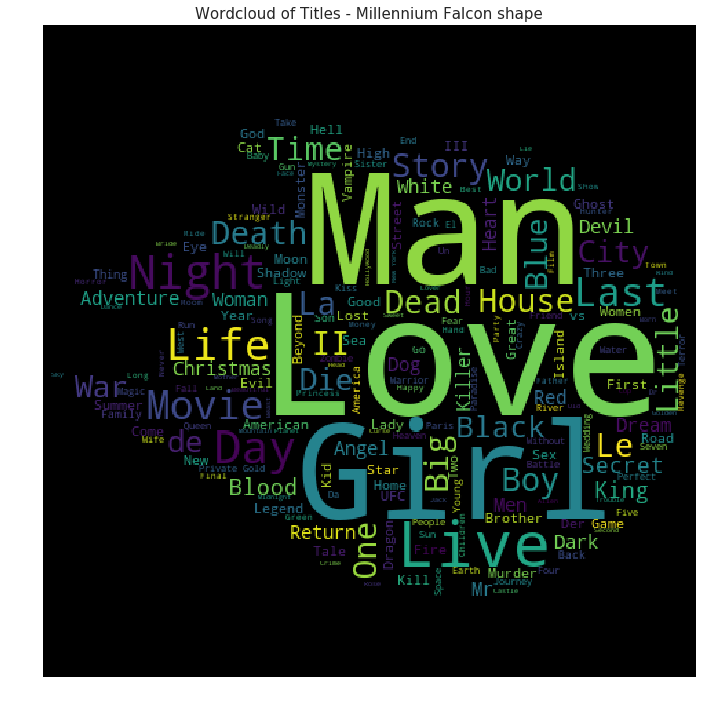

In [62]:
title_wordcloud = WordCloud(mask=mask, stopwords=STOPWORDS, background_color='black', height=2000, width=2000, random_state=1).generate(title_corpus)
plt.figure(figsize=(12,12))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.title("Wordcloud of Titles - Millennium Falcon shape")
plt.show()

## Overview

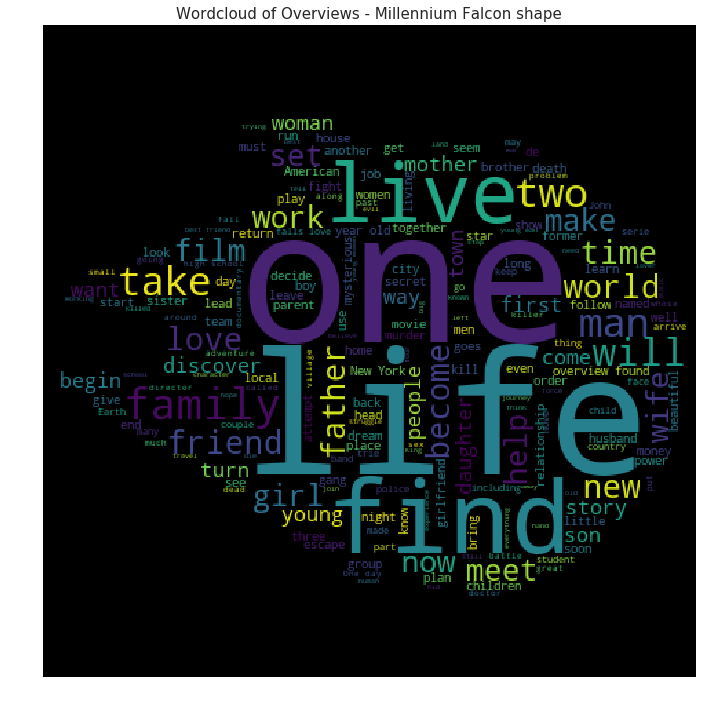

In [63]:
overview_wordcloud = WordCloud(mask=mask, stopwords=STOPWORDS, background_color='black', height=2000, width=2000, random_state=1).generate(overview_corpus)
plt.figure(figsize=(12,12))
plt.imshow(overview_wordcloud)
plt.axis('off')
plt.title("Wordcloud of Overviews - Millennium Falcon shape")
plt.show()

## Production Country

In [64]:
productionCountry = pd.read_sql_query("SELECT DISTINCT name as country, COUNT(name) as movies_counted FROM productioncountries WHERE country NOT IN ('') GROUP BY name ORDER BY movies_counted DESC ;", con)

In [65]:
productionCountry.head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
country,United States of America,France,United Kingdom,Germany,Japan,Italy,Canada,India,Spain,Hong Kong
movies_counted,25621,5058,4366,3397,3126,2546,2142,1637,1509,1380


> A map of countries showing density of directed movies
    - https://plot.ly/~KonradBorowiec/2

In [66]:
data = [ dict(
        type = 'choropleth',
        locations = productionCountry['country'],
        locationmode = 'country names',
        z = productionCountry['movies_counted'],
        text = productionCountry['country'],
        colorscale = [[0,'rgb(255, 255, 255)'],[1,'rgb(0, 153, 51)']],
        autocolorscale = False,
        reversescale = False,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Count'),
      ) ]

layout = dict(
    title = 'Number of movies per country',
    geo = dict(
        showframe = True,
        showcoastlines = True,
        projection = dict(
            type = 'Orthographic'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='d3-world-map' )

/home/konrad/anaconda3/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



## Original Language

In [67]:
movies = pd.read_sql_query("SELECT DISTINCT original_language, COUNT(original_language) as count FROM movies WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23') GROUP BY original_language ORDER BY count DESC ;", con)

In [68]:
movies.head(20).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
original_language,en,de,fr,it,ja,es,ru,cn,da,hi,ko,zh,sv,ta,pt,nl,tr,cs,pl,fi
count,56987,40798,2943,1657,1525,940,710,590,546,530,484,440,399,285,266,265,233,211,186,184


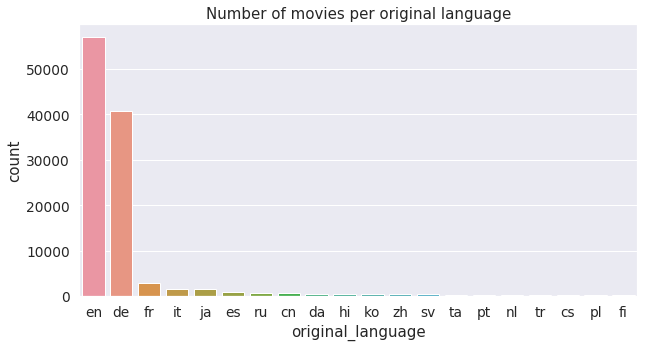

In [69]:
plt.figure(figsize=(10,5))
plt.title("Number of movies per original language")
sns.barplot(x = 'original_language', y = 'count', data = movies.iloc[0:20])
plt.show()

## Popularity

> Subseting movies dataset, creating a year field

In [70]:
movies = pd.read_sql_query("SELECT DISTINCT movies.title, movies.id, movies.imdb_id, movies.release_date, movies.budget, movies.popularity, movies.revenue, movies.vote_count, movies.vote_average, movies.runtime, strftime('%Y', datetime(release_date)) as year, movies.status FROM movies as movies WHERE release_date NOT IN ('') AND imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23');", con)

In [71]:
movies.head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
title,Ariel,Shadows in Paradise,Four Rooms,Judgment Night,Life in Loops (A Megacities RMX),Sunday in August,Star Wars,Finding Nemo,Forrest Gump,American Beauty
id,2,3,5,6,8,9,11,12,13,14
imdb_id,tt0094675,tt0092149,tt0113101,tt0107286,tt0825671,tt0425473,tt0076759,tt0266543,tt0109830,tt0169547
release_date,1988-10-21,1986-10-17,1995-12-09,1993-10-15,2006-01-01,2004-09-02,1977-05-25,2003-05-30,1994-07-06,1999-09-15
budget,0,0,4000000,21,42000,0,11000000,94000000,55000000,15000000
popularity,5.603,3.789,9.823,6.935,0.6,0.952,33.015,25.552,23.149,18.132
revenue,0,0,4.3e+06,12,0,0,7.75398e+08,9.40336e+08,6.77945e+08,3.56297e+08
vote_count,66,48,996,107,5,3,10413,10362,13098,5758
vote_average,6.9,7.2,6.3,6.5,6.8,6.5,8.2,7.8,8.4,8
runtime,73,72,98,110,80,15,121,100,142,122


> Setting data type for popularity, vote_couunt, vote_avarage, revenue, runtime fields

In [72]:
def clean_numeric(x):
    try:
        return float(x)
    except:
        return np.nan

In [73]:
movies['popularity'] = movies['popularity'].apply(clean_numeric).astype('float')
movies['vote_count'] = movies['vote_count'].apply(clean_numeric).astype('float')
movies['vote_average'] = movies['vote_average'].apply(clean_numeric).astype('float')
movies['revenue'] = movies['revenue'].apply(clean_numeric).astype('float')
movies['runtime'] = movies['runtime'].apply(clean_numeric).astype('float')

> Popularity summary statistics 

In [74]:
movies['popularity'].describe()

count    47501.000000
mean         2.119118
std          2.642135
min          0.600000
25%          0.632000
50%          1.129000
75%          2.223000
max         49.011000
Name: popularity, dtype: float64

> Popularity histogram with density function

/home/konrad/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



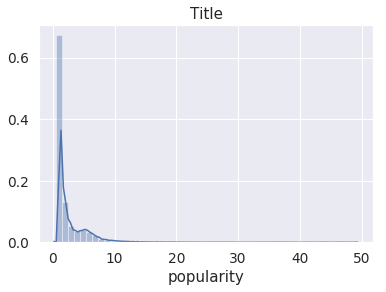

In [75]:
sns.distplot(movies['popularity'].fillna(movies['popularity'].median()))
plt.title("Title")
plt.show()

> Popularity histogram on a logarithmic scale base 10

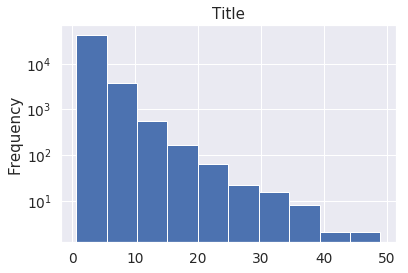

In [76]:
plt.title("Title")
movies['popularity'].plot(logy=True, kind='hist')

> Movies with highest value of popularity

In [77]:
popularity = pd.read_sql_query("SELECT DISTINCT title, popularity, strftime('%Y', datetime(release_date)) as year FROM movies as movies WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23') ORDER BY popularity DESC;", con)

> Movies with highest value of popularity

In [78]:
popularity.head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
title,,The Avengers,Harry Potter and the Philosopher's Stone,Pirates of the Caribbean: The Curse of the Bla...,The Lord of the Rings: The Fellowship of the Ring,Eternal Sunshine of the Spotless Mind,Harry Potter and the Chamber of Secrets,The Dark Knight,Die Hard,Titanic
popularity,,49.011,46.233,44.059,42.996,38.463,38.096,36.251,36.091,35.888
year,None,2012,2001,2003,2001,2004,2002,2008,1988,1997


> Movies with lowest value of popularity

In [79]:
popularity.tail(10).transpose()

,47733,47734,47735,47736,47737,47738,47739,47740,47741,47742
title,The Story of Molly X,Sesame Street: All-Star Alphabet,The True Meaning of Pictures: Shelby Lee Adams...,Roy Chubby Brown: Dirty Weekend in Blackpool Live,Charisma,Roy Chubby Brown: Too Fat To Be Gay,The Blue Light,Lucky Dog,BlackJack: In the Money,BlackJack- Sweet Science
popularity,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6
year,1949,2005,2002,2008,1999,2009,1932,2008,2005,2004


## Vote Count

> vote_count summary statistics

In [80]:
movies['vote_count'].describe()

count    47501.000000
mean       117.362582
std        612.931402
min          0.000000
25%          2.000000
50%          8.000000
75%         29.000000
max      20214.000000
Name: vote_count, dtype: float64

> Movies with highest value of vote_count

In [81]:
movies[['title', 'vote_count', 'year']].sort_values('vote_count', ascending=False).head(10).transpose()

,15966,14140,119,11893,430,45031,1152,552,46018,87
title,Inception,The Avengers,The Dark Knight,Avatar,Fight Club,Django Unchained,Iron Man,Pulp Fiction,The Hunger Games,The Lord of the Rings: The Fellowship of the Ring
vote_count,20214,17421,17273,17165,14746,14282,13741,13582,13480,13126
year,2010,2012,2008,2009,1999,2012,2008,1994,2012,2001


> Movies with lowest value of vote_count

In [82]:
movies[['title', 'vote_count', 'year']].sort_values('vote_count', ascending=False).tail(10).transpose()

,43530,43522,43529,43528,13531,43526,43525,37933,43523,40518
title,Ullasa Paravaigal,Savaal,Ram Lakshman,Kadal Meengal,Little Brown Jug,Sankarlal,Ellam Inbamayyam,Shaolin Temple Against Lama,Raja Paarvai,A+ Pollux
vote_count,0,0,0,0,0,0,0,0,0,0
year,1980,1981,1981,1981,1948,1981,1981,1980,1981,2002


## Vote Average

> vote_average summary statistics

In [83]:
movies['vote_average'] = movies['vote_average'].replace(0, np.nan)
movies['vote_average'].describe()

count    43021.000000
mean         5.944899
std          1.372613
min          0.500000
25%          5.200000
50%          6.100000
75%          6.900000
max         10.000000
Name: vote_average, dtype: float64

> vote_average histogram with density function

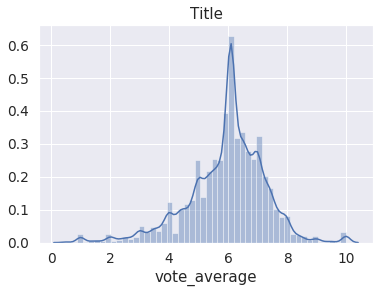

In [84]:
plt.title("Title")
sns.distplot(movies['vote_average'].fillna(movies['vote_average'].median()))

> Top 10 vote_average

In [85]:
voteAverage = movies[['title', 'vote_average', 'popularity','vote_count' ,'year']].sort_values('vote_average', ascending=False)
voteAverage.head(10).transpose()

,43547,30521,42446,39181,24344,44940,44953,20096,27784,30518
title,Parthal Pasi Theerum,Kudo Shinichi Returns! Showdown with the Black...,Ghost Stories,Arsenal 49 - The Complete Unbeaten Record,Private Gold 50: Exotic Illusions 2,Simpsons The XXX Parody,Heart - Night at Sky Church,Derren Brown: An Evening of Wonders,Tom Brown's School Days,Oingo Boingo: Farewell (Live from the Universa...
vote_average,10,10,10,10,10,10,10,10,10,10
popularity,1.371,0.873,0.6,0.6,0.9,0.6,0.6,0.623,0.901,0.871
vote_count,1,1,1,1,1,1,1,1,2,1
year,1962,2007,1987,2004,2001,2011,2011,2009,1940,1996


> Top 10 vote_average where vote_count is greater than x

In [86]:
x = 10000

In [87]:
voteAverage[voteAverage['vote_count'] >= x][['title', 'popularity','vote_average', 'vote_count' ,'year']].sort_values('vote_average', ascending=False).head(10).transpose()

,232,89,119,552,8,430,87,6,15966,88
title,The Shawshank Redemption,The Lord of the Rings: The Return of the King,The Dark Knight,Pulp Fiction,Forrest Gump,Fight Club,The Lord of the Rings: The Fellowship of the Ring,Star Wars,Inception,The Lord of the Rings: The Two Towers
popularity,33.146,32.151,36.251,29.612,23.149,33.581,42.996,33.015,35.524,29.548
vote_average,8.6,8.4,8.4,8.4,8.4,8.4,8.3,8.2,8.2,8.2
vote_count,11809,11955,17273,13582,13098,14746,13126,10413,20214,11324
year,1994,2003,2008,1994,1994,1999,2001,1977,2010,2002


> Scatter plot of popularity vs vote_average

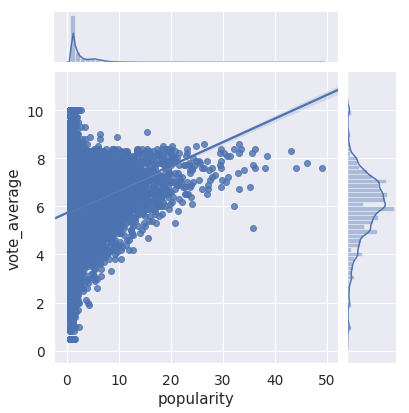

In [88]:
sns.jointplot(x='popularity', y='vote_average', data=voteAverage, kind='reg')

> Scatter plot of popularity vs vote_average on a logarithmic scale base 10

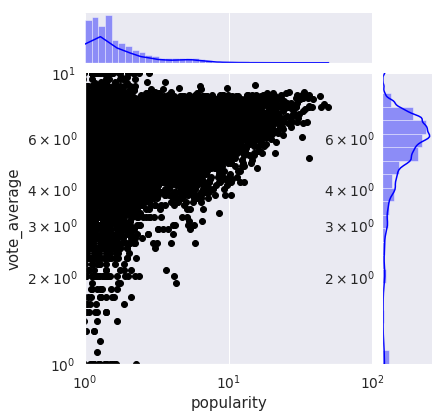

In [89]:
mybins=np.logspace(0,np.log(100),100)
g = sns.JointGrid(x='popularity', y='vote_average', data=voteAverage, xlim=[1,100],ylim=[1,10])
g.plot_marginals(sns.distplot, hist=True, kde=True, color='blue',bins=mybins)
g.plot_joint(plt.scatter, color='black', edgecolor='black')
ax = g.ax_joint
ax.set_xscale('log')
ax.set_yscale('log')
g.ax_marg_x.set_xscale('log')
g.ax_marg_y.set_yscale('log')

> Scatter plot of vote_count vs vote_average

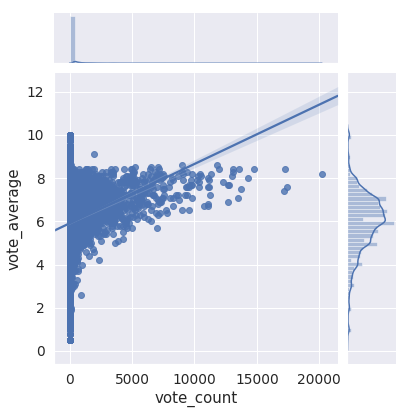

In [90]:
sns.jointplot(x='vote_count', y='vote_average', data=voteAverage, kind='reg')

> Scatter plot of vote_count vs vote_average on a logarithmic scale base 10

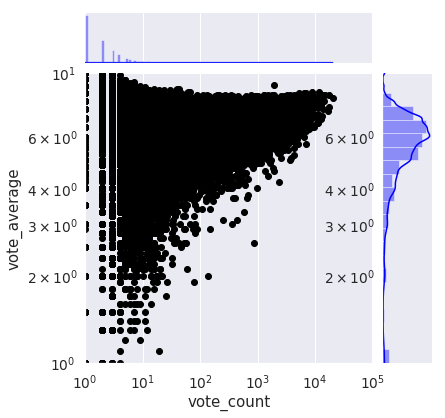

In [91]:
mybins=np.logspace(0,np.log(100),100)
g = sns.JointGrid(x='vote_count', y='vote_average', data=voteAverage, xlim=[1,100000],ylim=[1,10])
g.plot_marginals(sns.distplot, hist=True, kde=True, color='blue',bins=mybins)
g.plot_joint(plt.scatter, color='black', edgecolor='black')
ax = g.ax_joint
ax.set_xscale('log')
ax.set_yscale('log')
g.ax_marg_x.set_xscale('log')
g.ax_marg_y.set_yscale('log')

> Scatter plot of vote_count vs popularity

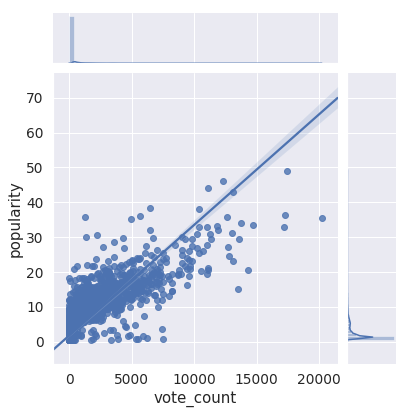

In [92]:
sns.jointplot(x='vote_count', y='popularity', data=voteAverage, kind='reg')

> Scatter plot of vote_count vs popularity on a logarithmic scale base 10

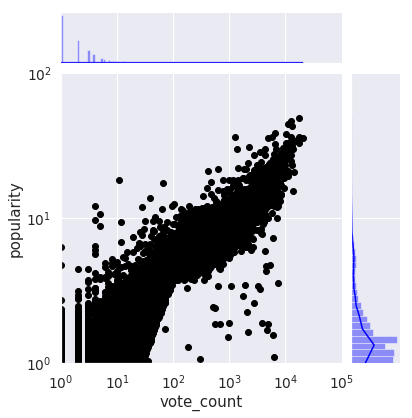

In [93]:
mybins=np.logspace(0,np.log(100),100)
g = sns.JointGrid(x='vote_count', y='popularity', data=voteAverage, xlim=[1,100000],ylim=[1,100])
g.plot_marginals(sns.distplot, hist=True, kde=True, color='blue',bins=mybins)
g.plot_joint(plt.scatter, color='black', edgecolor='black')
ax = g.ax_joint
ax.set_xscale('log')
ax.set_yscale('log')
g.ax_marg_x.set_xscale('log')
g.ax_marg_y.set_yscale('log')

## Release date

> Number of released movies per month

In [101]:
def get_month(x):
    try:
        return month_order[int(str(x).split('-')[1]) - 1]
    except:
        return np.nan

In [102]:
def get_day(x):
    try:
        year, month, day = (int(i) for i in x.split('-'))    
        answer = datetime.date(year, month, day).weekday()
        return day_order[answer]
    except:
        return np.nan

In [103]:
movies['day'] = movies['release_date'].apply(get_day)
movies['month'] = movies['release_date'].apply(get_month)

In [104]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

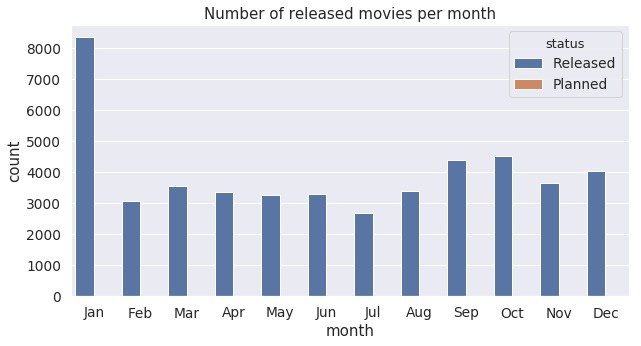

In [105]:
plt.figure(figsize=(10,5))
plt.title("Number of released movies per month")
sns.countplot(x='month', hue='status', data=movies, order=month_order)

In [106]:
x = 100000000

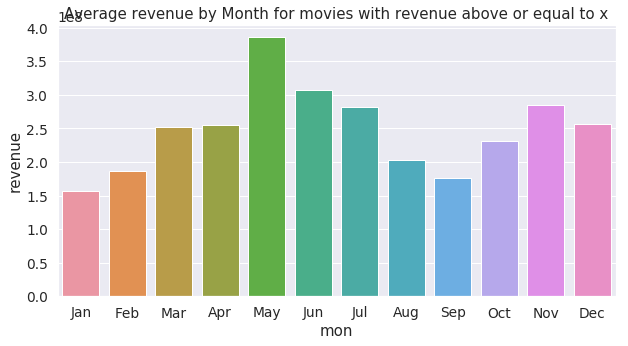

In [107]:
monthMean = pd.DataFrame(movies[movies['revenue'] >= x].groupby('month')['revenue'].mean())
monthMean['mon'] = monthMean.index
plt.figure(figsize=(10,5))
plt.title("Average revenue by Month for movies with revenue above or equal to x")
sns.barplot(x='mon', y='revenue', data=monthMean, order=month_order)

> Defining new field return rate

In [108]:
movies['return'] = movies['revenue'] / movies['budget']
movies['return'] = movies['return'].apply(clean_numeric).astype('float')

> Distribution of rate per month

(0, 12)

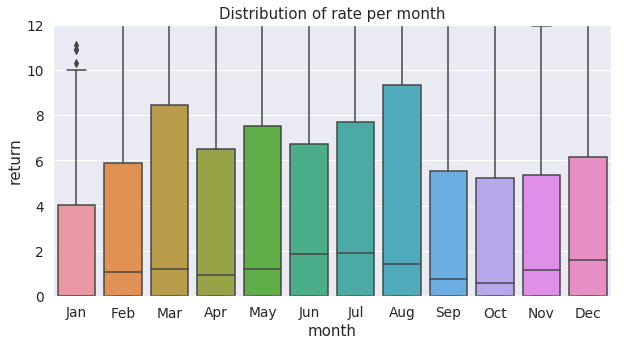

In [109]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10, 5))
plt.title('Distribution of rate per month')
sns.boxplot(x='month', y='return', data=movies[movies['return'].notnull()], ax =ax, order=month_order)
ax.set_ylim([0, 12])

> Number of movies realeased on a specific weekday

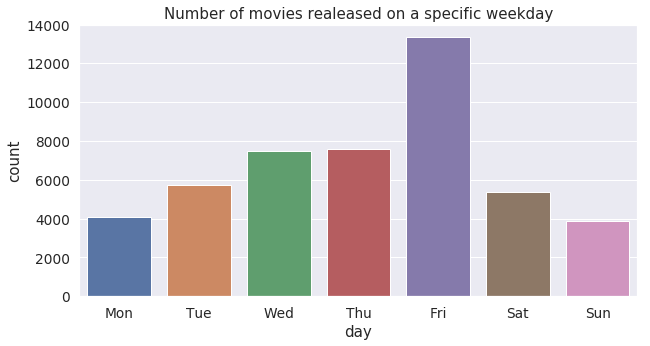

In [110]:
plt.figure(figsize=(10,5))
plt.title("Number of movies realeased on a specific weekday")
sns.countplot(x='day', data=movies, order=day_order)

> Number of movies per year. The data set is undersampled for most recent years

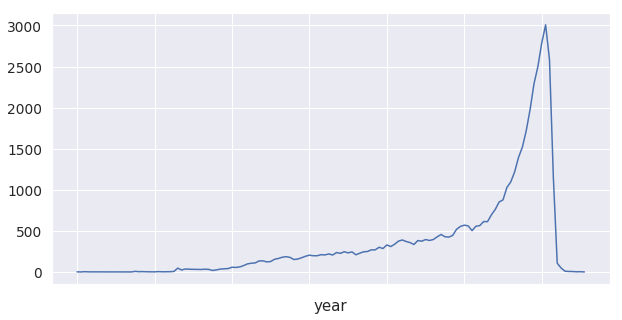

In [111]:
yearCount = movies.groupby('year')['title'].count()
plt.figure(figsize=(10,5))
yearCount.plot()

> Number of movies per year on a logarithmic scale. The data set is undersampled for most recent years

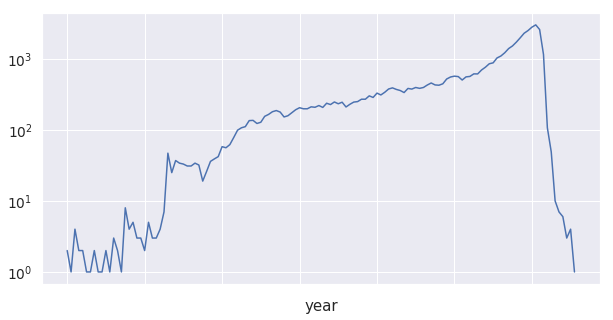

In [112]:
yearCount = movies.groupby('year')['title'].count()
plt.figure(figsize=(10,5))
yearCount.plot(logy=True)

> Oldest movies in movie data set

In [113]:
movies[movies['year'] != 'NaT'][['title', 'year']].sort_values('year').head(10).transpose()

,9886,9887,19808,20274,20275,19889,20276,20277,20232,9945
title,Roundhay Garden Scene,Traffic Crossing Leeds Bridge,"Leisurely Pedestrians, Open Topped Buses and H...","Monkeyshines, No. 2",London's Trafalgar Square,"Monkeyshines, No. 1","Monkeyshines, No. 3",Men Boxing,Dickson Greeting,Un bon bock
year,1888,1888,1889,1890,1890,1890,1890,1891,1891,1892


> Number of released movies by year and month

In [114]:
months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

In [115]:
moviesYear = movies[movies['year'] >='1988']
heatMap = pd.pivot_table(data=moviesYear, index='month', columns='year', aggfunc='count', values='title')
heatMap = heatMap.fillna(0)

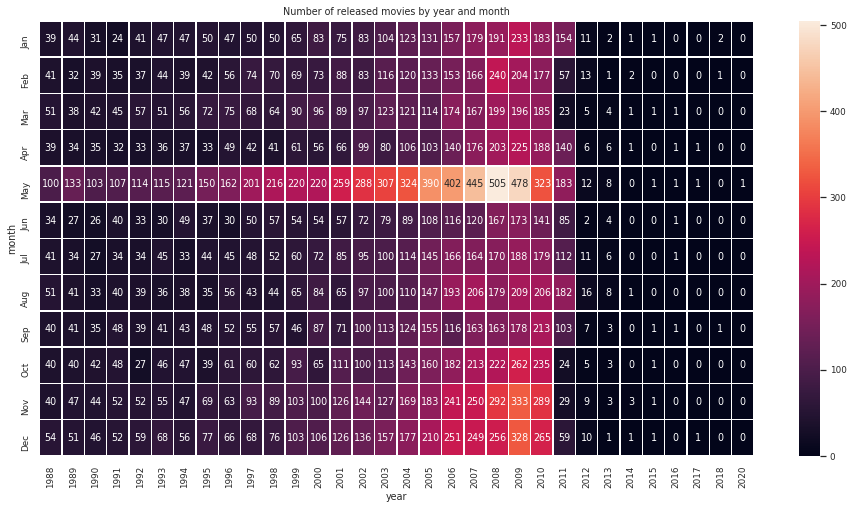

In [116]:
sns.set(font_scale=0.8)
f, ax = plt.subplots(figsize=(16, 8))
plt.title("Number of released movies by year and month")
sns.heatmap(heatMap, annot=True, linewidths=.5, ax=ax, fmt='n', yticklabels=month_order)

In [117]:
sns.set(font_scale=1.25)

## Status

> Status summary statistics

In [118]:
movies['status'].value_counts()

Released    47500
Planned         1
Name: status, dtype: int64

## Runtime

> Runtime summary statistics

In [119]:
movies['runtime'].describe()

count    44428.000000
mean        94.968488
std         35.034685
min          1.000000
25%         85.000000
50%         94.000000
75%        106.000000
max       1635.000000
Name: runtime, dtype: float64

> Distribution of runtime

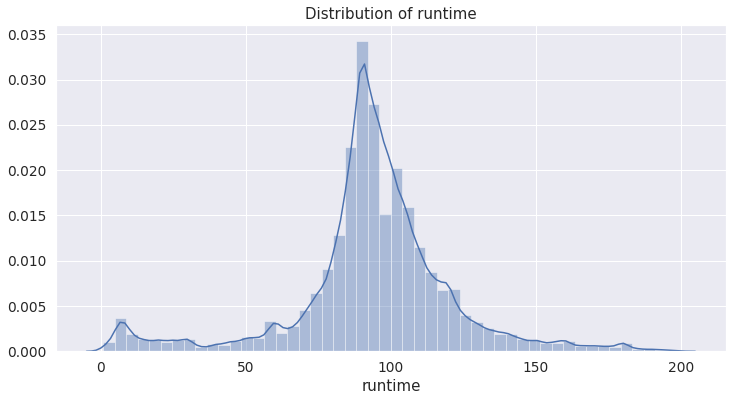

In [120]:
plt.figure(figsize=(12,6))
plt.title("Distribution of runtime")
sns.distplot(movies[(movies['runtime'] < 200) & (movies['runtime'] > 0)]['runtime'],)

> Scatter plot of runtime vs return

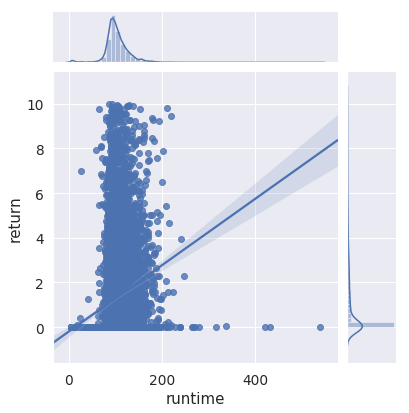

In [121]:
df = movies[(movies['return'].notnull()) & (movies['runtime'] > 0) & (movies['return'] < 10)]
sns.jointplot('runtime', 'return', kind='reg', data=df)
plt.show()

> Scatter plot of runtime vs return on a logarithmic scale base 10

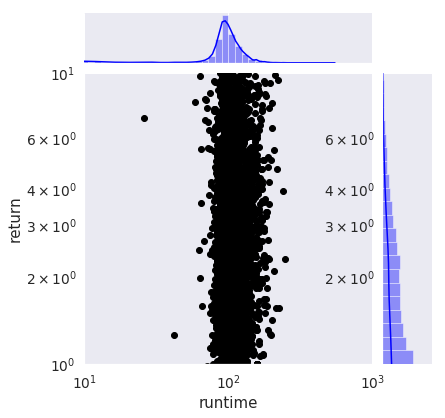

In [122]:
mybins=np.logspace(0,np.log(100),100)
g = sns.JointGrid(x='runtime', y='return', data=df, xlim=[10,1000],ylim=[1,10])
g.plot_marginals(sns.distplot, hist=True, kde=True, color='blue',bins=mybins)
g.plot_joint(plt.scatter, color='black', edgecolor='black')
ax = g.ax_joint
ax.set_xscale('log')
ax.set_yscale('log')
g.ax_marg_x.set_xscale('log')
g.ax_marg_y.set_yscale('log')

> Scatter plot of runtime vs budget

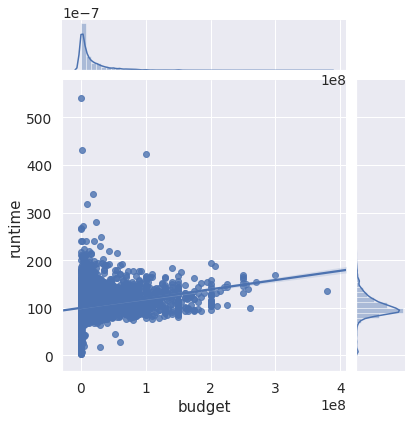

In [123]:
df = movies[(movies['budget'].notnull()) & (df['runtime'] > 0)]
sns.jointplot('budget', 'runtime', kind='reg', data=df)
plt.show()

> Scatter plot of runtime vs budget on a logarithmic scale base 10

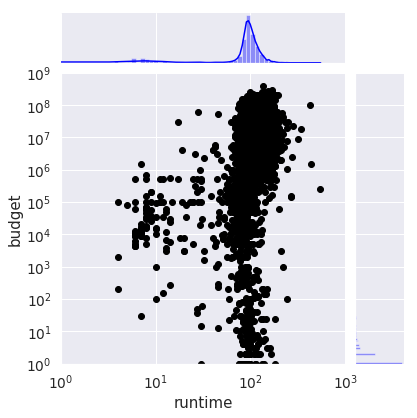

In [124]:
mybins=np.logspace(0,np.log(100),100)
g = sns.JointGrid(x='runtime', y='budget', data=df, xlim=[1,1000],ylim=[1,1000000000])
g.plot_marginals(sns.distplot, hist=True, kde=True, color='blue',bins=mybins)
g.plot_joint(plt.scatter, color='black', edgecolor='black')
ax = g.ax_joint
ax.set_xscale('log')
ax.set_yscale('log')
g.ax_marg_x.set_xscale('log')
g.ax_marg_y.set_yscale('log')

> Average runtime per year

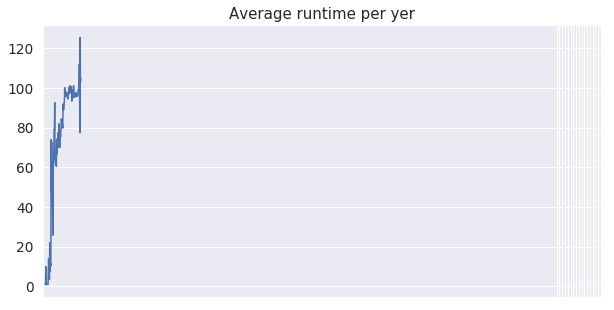

In [125]:
plt.figure(figsize=(10,5))
yearRuntime = movies[movies['year'] != 'NaT'].groupby('year')['runtime'].mean()
plt.title("Average runtime per yer")
plt.plot(yearRuntime.index, yearRuntime)
plt.xticks(np.arange(1850, 2020, 10.0))
plt.show()

> Top 10 of longest movies

In [126]:
longest = movies[movies['runtime'] > 0][['runtime', 'title', 'year']].sort_values('runtime', ascending=False)

In [127]:
longest.head(10).transpose()

,27052,44223,21734,29156,44215,47274,42070,26279,12690,40632
runtime,1635,1532,1440,931,925,735,730,566,553,543
title,UFC: The Ultimate 100 Greatest Fights,Heimat 2: A Chronicle of a Generation,24 Hours Berlin,Berlin Alexanderplatz,Heimat: A Chronicle of Germany,A Dream in Red Mansions,Edison: The Invention of the Movies,Shoah,Woody Woodpecker and Friends,Long Way Down
year,2009,1992,2009,1980,1984,1988,2005,1985,1982,2010


> Top 10 of shortest movies

In [128]:
shortest = movies[movies['runtime'] > 0][['runtime', 'title', 'year']].sort_values('runtime')

In [129]:
shortest.head(10).transpose()

,45123,20277,33969,20875,40328,45377,45363,45183,31234,9886
runtime,1,1,1,1,1,1,1,1,1,1
title,The Perfect Man,Men Boxing,The Big Sellout,"The Execution of Mary, Queen of Scots",Ice Egg,X-Ray Men from Mars,No Neck Joe,Sunny Havens,Scaredy Cat!,Roundhay Garden Scene
year,1997,1891,2007,1895,2002,1978,1996,1995,1989,1888


## Budget

> Budget summary statistics

In [130]:
movies['budget'].describe()

count    4.750100e+04
mean     3.183345e+06
std      1.466734e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.800000e+08
Name: budget, dtype: float64

> Budget histogram with density function

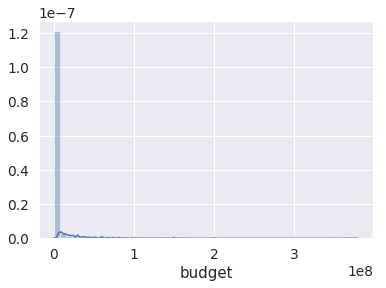

In [131]:
sns.distplot(movies[movies['budget'].notnull()]['budget'])

> Budget histogram on a logarithmic scale base 10

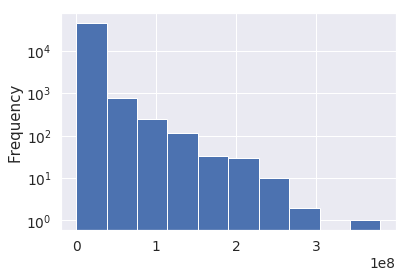

In [132]:
movies['budget'].plot(logy=True, kind='hist')

> Top 10 movies with largest budget

In [133]:
largestBudget = movies[movies['budget'].notnull()][['title', 'budget', 'revenue', 'return', 'year']].sort_values('budget', ascending=False)

In [134]:
largestBudget.head(10).transpose()

,1239,237,970,23690,438,37577,32175,608,31786,37555
title,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: At World's End,Superman Returns,Tangled,Spider-Man 3,The Lone Ranger,John Carter,Harry Potter and the Half-Blood Prince,The Hobbit: An Unexpected Journey,The Hobbit: The Desolation of Smaug
budget,380000000,300000000,270000000,260000000,258000000,255000000,250000000,250000000,250000000,250000000
revenue,1.04571e+09,9.61e+08,3.91081e+08,5.91795e+08,8.90872e+08,8.92899e+07,2.84139e+08,9.33959e+08,1.0211e+09,9.584e+08
return,2.75188,3.20333,1.44845,2.27613,3.45299,0.350157,1.13656,3.73584,4.08441,3.8336
year,2011,2007,2006,2010,2007,2013,2012,2009,2012,2013


> Average budget by year

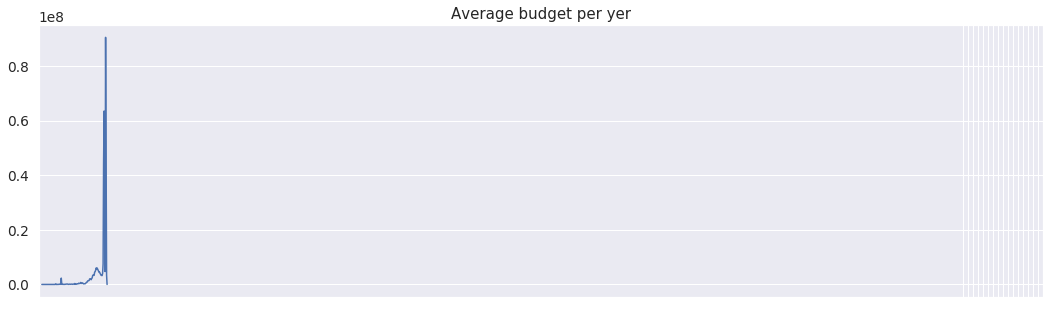

In [135]:
plt.figure(figsize=(18,5))
year_revenue = movies[(movies['budget'].notnull()) & (movies['year'] != 'NaT')].groupby('year')['budget'].mean()
plt.plot(year_revenue.index, year_revenue)
plt.title("Average budget per yer")
plt.xticks(np.arange(1850, 2020, 10.0))
plt.show()

> Scatter plot of budget vs revenue

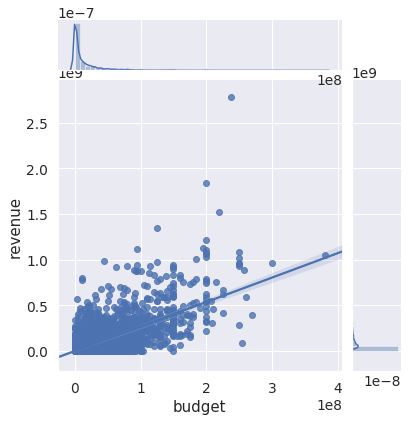

In [136]:
sns.jointplot(x='budget',y='revenue', kind='reg', data=movies[movies['return'].notnull()])

> Scatter plot of runtime vs budget on a logarithmic scale base 10

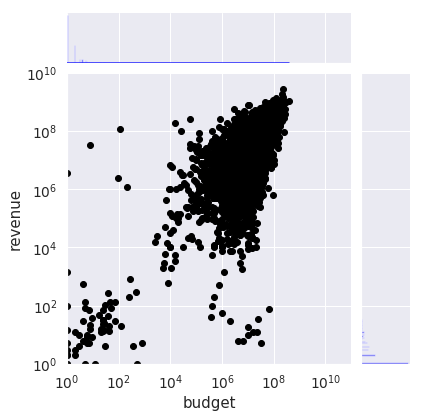

In [137]:
mybins=np.logspace(0,np.log(100),100)
g = sns.JointGrid(x='budget', y='revenue', data=movies, xlim=[1,100000000000],ylim=[1,10000000000])
g.plot_marginals(sns.distplot, hist=True, kde=True, color='blue',bins=mybins)
g.plot_joint(plt.scatter, color='black', edgecolor='black')
ax = g.ax_joint
ax.set_xscale('log')
ax.set_yscale('log')
g.ax_marg_x.set_xscale('log')
g.ax_marg_y.set_yscale('log')

> Scatter plot of budget vs vote_count

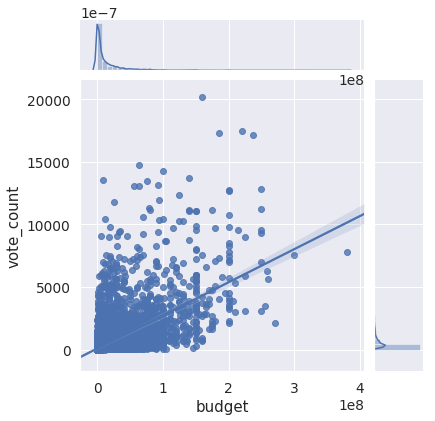

In [138]:
sns.jointplot(x='budget',y='vote_count', kind='reg', data=movies[movies['return'].notnull()])

> Scatter plot of budget vs vote_count on a logarithmic scale base 10

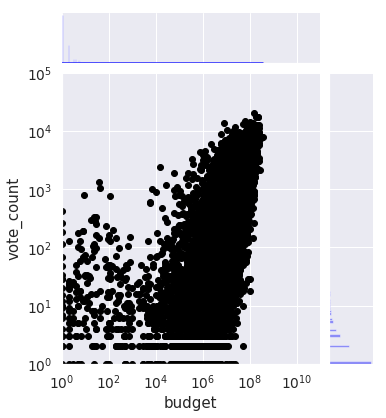

In [139]:
mybins=np.logspace(0,np.log(100),100)
g = sns.JointGrid(x='budget', y='vote_count', data=movies, xlim=[1,100000000000],ylim=[1,100000])
g.plot_marginals(sns.distplot, hist=True, kde=True, color='blue',bins=mybins)
g.plot_joint(plt.scatter, color='black', edgecolor='black')
ax = g.ax_joint
ax.set_xscale('log')
ax.set_yscale('log')
g.ax_marg_x.set_xscale('log')
g.ax_marg_y.set_yscale('log')

> Scatter plot of budget vs vote_average

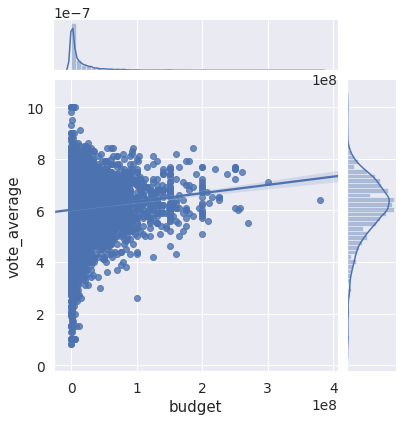

In [140]:
sns.jointplot(x='budget',y='vote_average', kind='reg', data=movies[movies['return'].notnull()])

> Scatter plot of budget vs vote_average on a logarithmic scale base 10

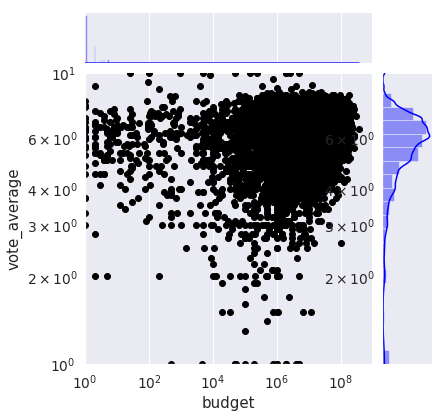

In [141]:
mybins=np.logspace(0,np.log(100),100)
g = sns.JointGrid(x='budget', y='vote_average', data=movies, xlim=[1,1000000000],ylim=[1,10])
g.plot_marginals(sns.distplot, hist=True, kde=True, color='blue',bins=mybins)
g.plot_joint(plt.scatter, color='black', edgecolor='black')
ax = g.ax_joint
ax.set_xscale('log')
ax.set_yscale('log')
g.ax_marg_x.set_xscale('log')
g.ax_marg_y.set_yscale('log')

> Scatter plot of budget vs popularity

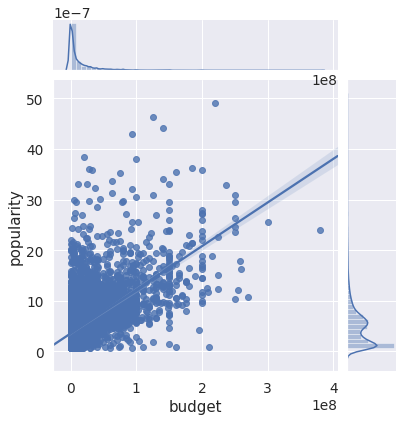

In [142]:
sns.jointplot(x='budget',y='popularity', kind='reg', data=movies[movies['return'].notnull()])

> Scatter plot of budget vs popularity on a logarithmic scale base 10

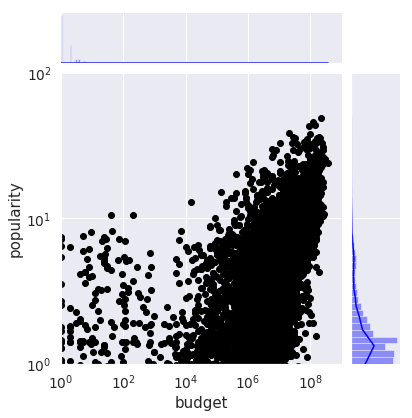

In [143]:
mybins=np.logspace(0,np.log(100),100)
g = sns.JointGrid(x='budget', y='popularity', data=movies, xlim=[1,1000000000],ylim=[1,100])
g.plot_marginals(sns.distplot, hist=True, kde=True, color='blue',bins=mybins)
g.plot_joint(plt.scatter, color='black', edgecolor='black')
ax = g.ax_joint
ax.set_xscale('log')
ax.set_yscale('log')
g.ax_marg_x.set_xscale('log')
g.ax_marg_y.set_yscale('log')

## Revenue

> Revenue summary statistics

In [144]:
movies['revenue'].describe()

count    4.750100e+04
mean     8.149055e+06
std      5.195031e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.787965e+09
Name: revenue, dtype: float64

> Distribution of revenue

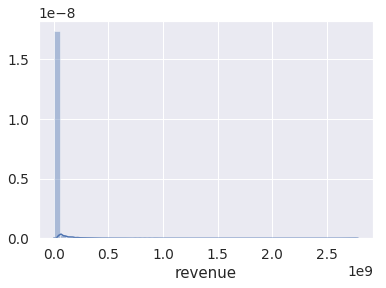

In [145]:
sns.distplot(movies[movies['revenue'].notnull()]['revenue'])

> Revenue histogram on a logarithmic scale base 10

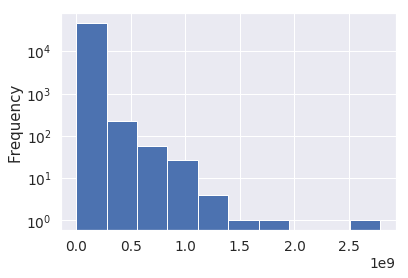

In [146]:
movies['revenue'].plot(logy=True, kind='hist')

> Top 10 most expensive movies

In [147]:
expensive = movies[['title', 'budget', 'revenue', 'year']].sort_values('revenue', ascending=False)

In [148]:
expensive.head(10).transpose()

,11893,473,14140,7078,45034,23394,89,22905,31769,5278
title,Avatar,Titanic,The Avengers,Harry Potter and the Deathly Hallows: Part 2,Iron Man 3,Transformers: Dark of the Moon,The Lord of the Rings: The Return of the King,Skyfall,The Dark Knight Rises,Toy Story 3
budget,237000000,200000000,220000000,125000000,200000000,195000000,94000000,200000000,250000000,200000000
revenue,2.78797e+09,1.84503e+09,1.51956e+09,1.342e+09,1.21544e+09,1.12375e+09,1.11889e+09,1.10856e+09,1.08494e+09,1.06697e+09
year,2009,1997,2012,2011,2013,2011,2003,2012,2012,2010


> Average revenue by year

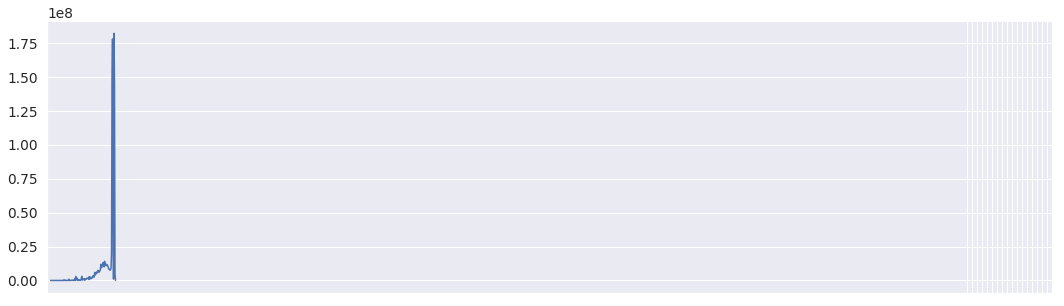

In [149]:
plt.figure(figsize=(18,5))
year_revenue = movies[(movies['revenue'].notnull()) & (movies['year'] != 'NaT')].groupby('year')['revenue'].mean()
plt.plot(year_revenue.index, year_revenue)
plt.xticks(np.arange(1850, 2029, 10.0))
plt.show()

> Scatter plot of revenue vs vote_count

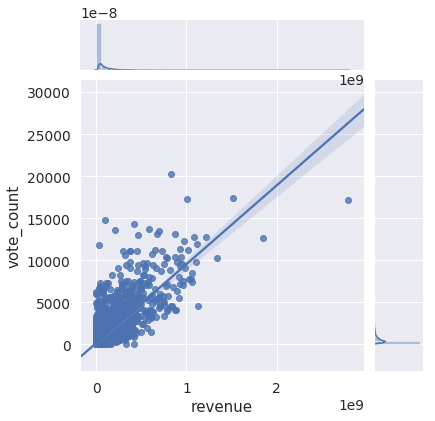

In [150]:
sns.jointplot(x='revenue',y='vote_count', kind='reg', data=movies[movies['return'].notnull()])

> Scatter plot of revenue vs vote_count on a logarithmic scale base 10

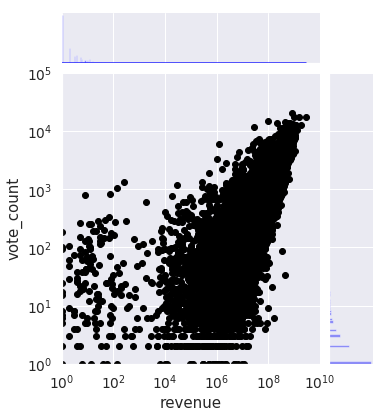

In [151]:
mybins=np.logspace(0,np.log(100),100)
g = sns.JointGrid(x='revenue', y='vote_count', data=movies, xlim=[1,10000000000],ylim=[1,100000])
g.plot_marginals(sns.distplot, hist=True, kde=True, color='blue',bins=mybins)
g.plot_joint(plt.scatter, color='black', edgecolor='black')
ax = g.ax_joint
ax.set_xscale('log')
ax.set_yscale('log')
g.ax_marg_x.set_xscale('log')
g.ax_marg_y.set_yscale('log')

> Scatter plot of revenue vs vote_average

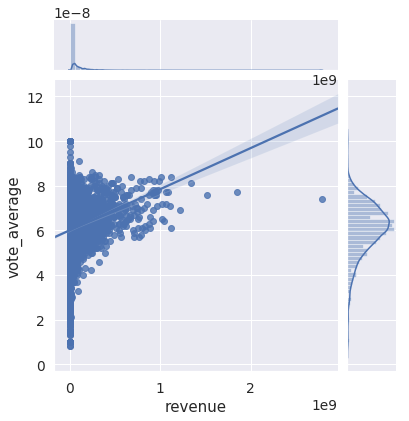

In [152]:
sns.jointplot(x='revenue',y='vote_average', kind='reg', data=movies[movies['return'].notnull()])

> Scatter plot of revenue vs vote_average on a logarithmic scale base 10

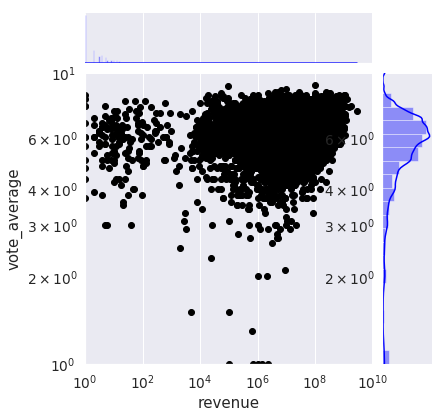

In [153]:
mybins=np.logspace(0,np.log(100),100)
g = sns.JointGrid(x='revenue', y='vote_average', data=movies, xlim=[1,10000000000],ylim=[1,10])
g.plot_marginals(sns.distplot, hist=True, kde=True, color='blue',bins=mybins)
g.plot_joint(plt.scatter, color='black', edgecolor='black')
ax = g.ax_joint
ax.set_xscale('log')
ax.set_yscale('log')
g.ax_marg_x.set_xscale('log')
g.ax_marg_y.set_yscale('log')

> Scatter plot of revenue vs popularity

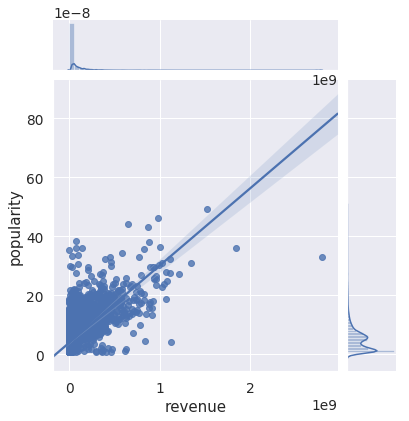

In [154]:
sns.jointplot(x='revenue',y='popularity', kind='reg', data=movies[movies['return'].notnull()])

> Scatter plot of revenue vs popularity on a logarithmic scale base 10

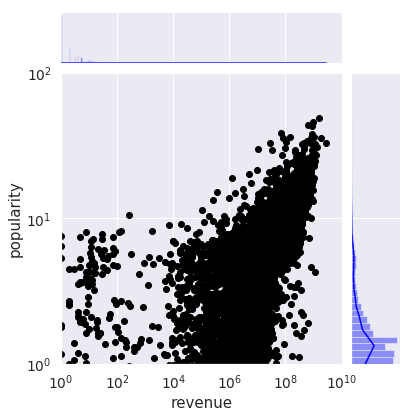

In [155]:
mybins=np.logspace(0,np.log(100),100)
g = sns.JointGrid(x='revenue', y='popularity', data=movies, xlim=[1,10000000000],ylim=[1,100])
g.plot_marginals(sns.distplot, hist=True, kde=True, color='blue',bins=mybins)
g.plot_joint(plt.scatter, color='black', edgecolor='black')
ax = g.ax_joint
ax.set_xscale('log')
ax.set_yscale('log')
g.ax_marg_x.set_xscale('log')
g.ax_marg_y.set_yscale('log')

## Return

> Return summary statistics

In [156]:
movies['return'].describe()

count    9603.000000
mean             inf
std              NaN
min         0.000000
25%         0.000000
50%         1.058528
75%         6.331203
max              inf
Name: return, dtype: float64

> Top 10 highest movie returns

In [157]:
highestReturn = movies[(movies['return'].notnull()) & (movies['budget'] > 5e6)][['title', 'budget', 'revenue', 'return', 'year']].sort_values('return', ascending=False)

In [158]:
highestReturn.head(10).transpose()

,477,6,455,4704,582,194,4652,56,8956,82
title,E.T. the Extra-Terrestrial,Star Wars,Jaws,The Exorcist,Four Weddings and a Funeral,The Godfather,Look Who's Talking,Dirty Dancing,The Sound of Music,Pretty Woman
budget,10500000,11000000,7000000,8000000,6000000,6000000,7500000,6000000,8200000,14000000
revenue,7.92965e+08,7.75398e+08,4.707e+08,4.41306e+08,2.54701e+08,2.45066e+08,2.96e+08,2.13894e+08,2.86214e+08,4.63e+08
return,75.5205,70.4907,67.2429,55.1633,42.4501,40.8444,39.4667,35.649,34.9042,33.0714
year,1982,1977,1975,1973,1994,1972,1989,1987,1965,1990


> Top 10 lowest movies returns

In [159]:
lowestReturn = df[(df['return'].notnull()) & (df['budget'] > 5e6) & (df['revenue'] > 10000)][['title', 'budget', 'revenue', 'return', 'year']].sort_values('return')

In [160]:
lowestReturn.head(10).transpose()

,2983,32938,2028,7781,9383,19362,4030,10583,2027,2026
title,Chaos,5 Days of War,"The Tulse Luper Suitcases, Part 3: From Sark t...",The Good Night,Cherry 2000,All The Queen's Men,The Red Baron,Freaked,"The Tulse Luper Suitcases, Part 2: Vaux to the...","The Tulse Luper Suitcases, Part 1: The Moab Story"
budget,20000000,20000000,10000000,15000000,10000000,15000000,18000000,13000000,10000000,10000000
revenue,10289,17479,12000,20380,14000,23000,40239,29296,24250,25800
return,0.00051445,0.00087395,0.0012,0.00135867,0.0014,0.00153333,0.0022355,0.00225354,0.002425,0.00258
year,2005,2011,2004,2007,1987,2001,2008,1993,2004,2003


## Correlation matrix

In [161]:
movies['year'] = movies['year'].replace('NaT', np.nan)

In [162]:
movies['year'] = movies['year'].apply(clean_numeric)

In [163]:
cm = df[['budget','revenue','return','popularity','runtime','vote_average','vote_count']]

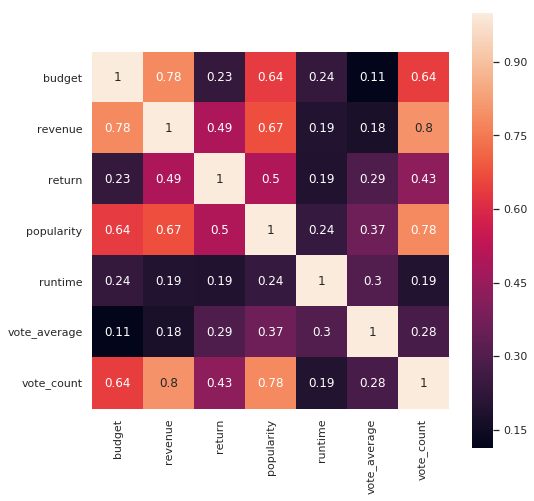

In [164]:
sns.set(font_scale=1)
corr = cm.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = False
with sns.axes_style("white"):
    plt.figure(figsize=(8,8))
    ax = sns.heatmap(corr, mask=mask, vmax=1, square=True, annot=True)

## Genres

> Most popular movie genres

In [165]:
genres = pd.read_sql_query("SELECT name, COUNT(id) AS id_counted FROM genres WHERE imdb_id <> '' GROUP BY name ORDER BY id_counted DESC;", con)

In [166]:
genres.head(20).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
name,Drama,Comedy,Action,Horror,Documentary,Crime,Animation,Adventure,Thriller,Music,Romance,Family,Fantasy,Science Fiction,Mystery,Western,TV Movie,War,History
id_counted,9593,8773,4351,2651,2476,1642,1474,1271,1110,969,892,640,597,502,438,341,321,232,207


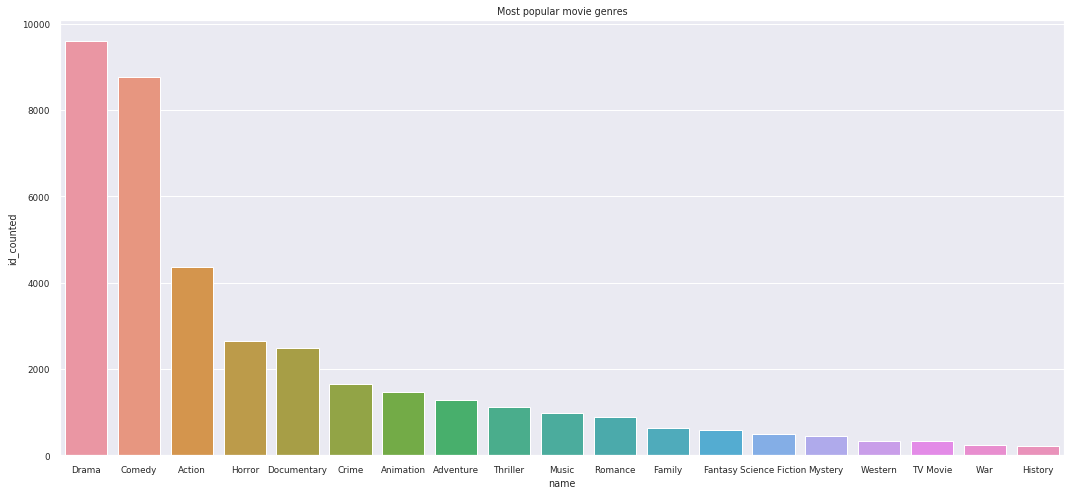

In [167]:
sns.set(font_scale=0.8)
plt.figure(figsize=(18,8))
plt.title('Most popular movie genres')
sns.barplot(x='name', y='id_counted', data=genres)
plt.show()

> Most popular movie genres by year

In [168]:
#genres = pd.read_sql_query("SELECT DISTINCT name AS genre FROM genres;", con)
gen_df = pd.read_sql_query("SELECT DISTINCT g.id, g.name AS genre, g.imdb_id, m.revenue, strftime('%Y', datetime(m.release_date)) as year FROM (SELECT DISTINCT * FROM genres WHERE imdb_id <> '') AS g INNER JOIN (SELECT DISTINCT * FROM movies WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23')) AS m ON g.imdb_id = m.imdb_id ORDER BY release_date DESC;", con)

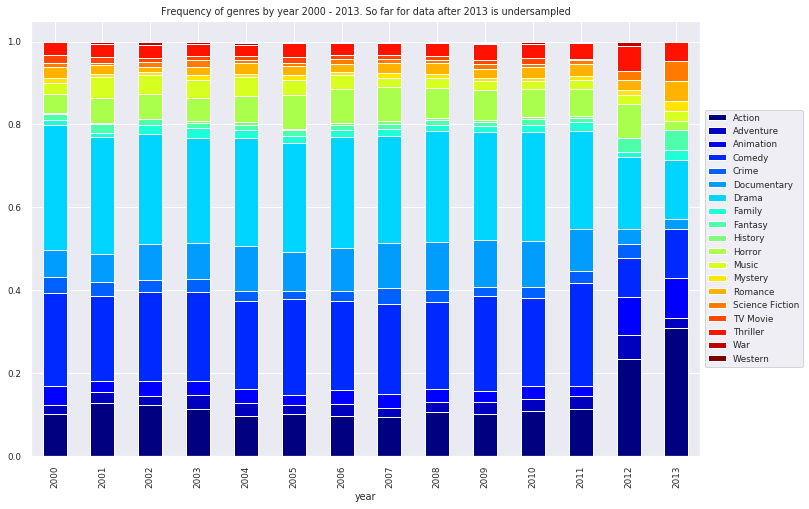

In [169]:
pop_gen_movies = gen_df[(gen_df['year'] >= '2000') & (gen_df['year'] <= '2013')]
ct = pd.crosstab([pop_gen_movies['year']], pop_gen_movies['genre']).apply(lambda x: x/x.sum(), axis=1)
#print(ctab)
ct.plot(kind='bar', stacked=True, colormap='jet', figsize=(12,8)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Frequency of genres by year 2000 - 2013. So far for data after 2013 is undersampled")
plt.show()

> Frequency of most popular genres by year

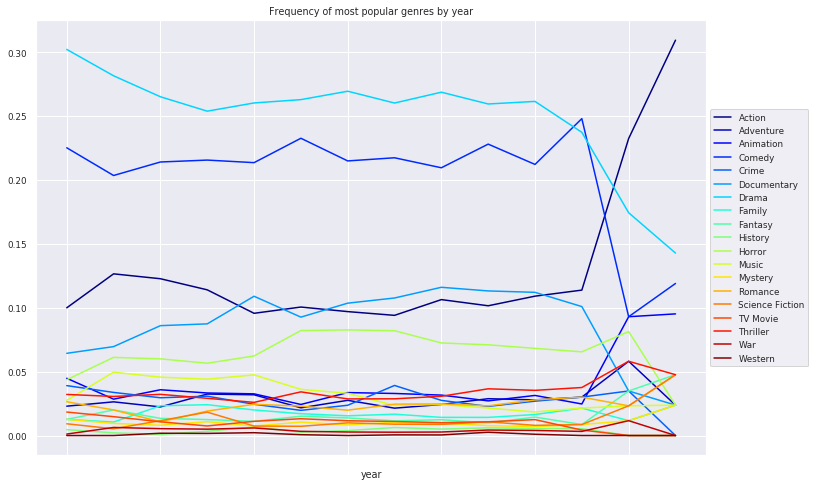

In [170]:
ct.plot(kind='line', stacked=False, colormap='jet', figsize=(12,8)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Frequency of most popular genres by year')
plt.show()

## Cast

## Crew

# Custom Score

> The value of X percentile for given distribution of vote_count:

In [171]:
percentile = 90

> Computing the value of cutoff

In [172]:
pd.read_sql_query("SELECT vote_count AS vote_count_" + str(percentile) + "_percentile FROM (SELECT DISTINCT * FROM MOVIES WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23')) ORDER BY vote_count ASC LIMIT 1 OFFSET (SELECT COUNT(*) FROM (SELECT DISTINCT * FROM MOVIES WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23'))) * " + str(percentile) + " / 100 - 1;", con)

,vote_count_90_percentile
0,139


> Bottom 10 movies after applying the cut off on vote_count

In [173]:
df = pd.read_sql_query("SELECT * FROM (SELECT DISTINCT * FROM MOVIES WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23')) WHERE vote_count > (SELECT vote_count AS vote_count_" + str(percentile) + "_percentile FROM (SELECT DISTINCT * FROM MOVIES WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23')) ORDER BY vote_count ASC LIMIT 1 OFFSET (SELECT COUNT(*) FROM (SELECT DISTINCT * FROM MOVIES WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23'))) * " + str(percentile) + " / 100 - 1) ORDER BY vote_count ASC;" , con)

In [174]:
df.head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
idx,0,0,0,0,0,0,0,0,0,0
budget,8000000,0,58000000,0,21000000,0,2800000,0,0,4000000
id,400,1721,2148,2517,10606,11223,11305,13691,15251,16873
imdb_id,tt0114660,tt0069095,tt0087089,tt0408664,tt0087910,tt0077355,tt0097940,tt0323642,tt0085474,tt0858486
original_language,en,it,en,ja,en,en,en,en,en,en
original_title,Things to Do in Denver When You're Dead,...più forte ragazzi!,The Cotton Club,誰も知らない,The Philadelphia Experiment,Coma,Mystery Train,Piglet's Big Movie,Eddie Murphy: Delirious,Battle for Terra
overview,A mafia film in Tarantino style with a star-st...,"The ""Trinity"" crew makes another modern era fi...",The story of the people that frequented Harlem...,"In a small Tokyo apartment, twelve-year-old Ak...","Based on an ""actual event"" that took place in ...",A young woman doctor discovers something sinis...,"A seedy hotel in Memphis, Tennessee, provides ...",When the gang from the Hundred Acre Wood begin...,Taped live and in concert at Constitution Hall...,"A peaceful alien planet faces annihilation, as..."
popularity,5.734,6.233,6.011,5.642,5.025,5.648,3.967,4.932,5.233,5.119
poster_path,/ysKIolKO0376Nl5DV1fDAAPudEq.jpg,/hfra5i11GjZf0pdwseA2OUDZkR5.jpg,/qigf5fWSH1tw7z424UVKg71UIOS.jpg,/kDQSwhkiHttHt0OlPNdmnrBsTki.jpg,/4J0n9oFLfdkcCA86bXCnViJKxzd.jpg,/wXhYCwf7yhnvlJxhl8nIcSWb4Aw.jpg,/vcr6pBGeHWfjiWH6HarEEXdJIlG.jpg,/gM4rWSXfPMeXorIKXNr5kuxLPkz.jpg,/nopK3L1aJYCuEiSQTqwpZD7uff7.jpg,/hE71YvRdNaILXxPf0iASqqFTCSv.jpg
release_date,1995-12-01,1972-12-22,1984-12-14,2004-08-07,1984-08-03,1978-01-06,1989-09-06,2003-03-16,1983-08-17,2007-09-06


> Top 10 movies basing on vote_count

In [175]:
pd.read_sql_query("SELECT * FROM (SELECT DISTINCT * FROM MOVIES WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23')) WHERE vote_count > (SELECT vote_count AS vote_count_" + str(percentile) + "_percentile FROM (SELECT DISTINCT * FROM MOVIES WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23')) ORDER BY vote_count ASC LIMIT 1 OFFSET (SELECT COUNT(*) FROM (SELECT DISTINCT * FROM MOVIES WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23'))) * " + str(percentile) + " / 100 - 1) ORDER BY vote_count ASC;" , con).tail(10).transpose()

,4764,4765,4766,4767,4768,4769,4770,4771,4772,4773
idx,0,0,0,0,0,0,0,0,0,0
budget,100000000,63000000,237000000,185000000,220000000,160000000,0,0,0,0
id,68718,550,19995,155,24428,27205,28102,52141,64659,67334
imdb_id,tt1853728,tt0137523,tt0499549,tt0468569,tt0848228,tt1375666,tt2061710,tt1585561,tt0416746,tt0436852
original_language,en,en,en,en,en,en,en,de,en,de
original_title,Django Unchained,Fight Club,Avatar,The Dark Knight,The Avengers,Inception,Ilse DeLange: Live In Ahoy,Die Fantastischen Vier: Heimspiel,Food Will Win the War,True Love
overview,"With the help of a German bounty hunter, a fre...",A ticking-time-bomb insomniac and a slippery s...,"In the 22nd century, a paraplegic Marine is di...",Batman raises the stakes in his war on crime. ...,When an unexpected enemy emerges and threatens...,"Cobb, a skilled thief who commits corporate es...",Tracklisting:,Tracklisting:,World War II propaganda film on the importance...,Seven short stories about growing up gay in Am...
popularity,20.567,33.581,32.934,36.251,49.011,35.524,,,,
poster_path,/5WJnxuw41sddupf8cwOxYftuvJG.jpg,/adw6Lq9FiC9zjYEpOqfq03ituwp.jpg,/kmcqlZGaSh20zpTbuoF0Cdn07dT.jpg,/1hRoyzDtpgMU7Dz4JF22RANzQO7.jpg,/cezWGskPY5x7GaglTTRN4Fugfb8.jpg,/qmDpIHrmpJINaRKAfWQfftjCdyi.jpg,,,,
release_date,2012-12-25,1999-10-15,2009-12-10,2008-07-16,2012-04-25,2010-07-15,,,,


> Global Average of vote_average

In [176]:
pd.read_sql_query("SELECT AVG(vote_average) as vote_average_global FROM (SELECT DISTINCT * FROM MOVIES WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23'));" , con)

,vote_average_global
0,5.368851


> Setting minimum size of vote_count per movie

In [177]:
MinimumVotes = 250.0

> Top 10 movies by Custom Score

In [178]:
customScore = pd.read_sql_query("SELECT id, imdb_id, title, vote_count, vote_average, (vote_count / (vote_count + MinimumVotes) * vote_average) + (MinimumVotes / (vote_count + MinimumVotes * VoteAvarageGlobal)) AS Score FROM (SELECT id, imdb_id, title, vote_count, " + str(MinimumVotes) + " as MinimumVotes, vote_average, (SELECT AVG(vote_average) FROM (SELECT DISTINCT * FROM MOVIES WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23'))) AS VoteAvarageGlobal FROM (SELECT * FROM (SELECT DISTINCT * FROM MOVIES WHERE imdb_id <> '') WHERE vote_count > (SELECT vote_count AS vote_count_" + str(percentile) + "_percentile FROM (SELECT DISTINCT * FROM MOVIES WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23')) ORDER BY vote_count ASC LIMIT 1 OFFSET (SELECT COUNT(*) FROM (SELECT DISTINCT * FROM MOVIES WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23'))) * " + str(percentile) + " / 100 - 1) ORDER BY vote_count ASC)) as ParametersForScore ORDER BY Score DESC;" , con)

In [179]:
customScore.head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
id,278,238,155,550,680,13,122,424,129,120
imdb_id,tt0111161,tt0068646,tt0468569,tt0137523,tt0110912,tt0109830,tt0167260,tt0108052,tt0245429,tt0120737
title,The Shawshank Redemption,The Godfather,The Dark Knight,Fight Club,Pulp Fiction,Forrest Gump,The Lord of the Rings: The Return of the King,Schindler's List,Spirited Away,The Lord of the Rings: The Fellowship of the Ring
vote_count,11809,9032,17273,14746,13582,13098,11955,7040,6546,13126
vote_average,8.6,8.6,8.4,8.4,8.4,8.4,8.4,8.5,8.5,8.3
Score,8.44072,8.39247,8.29359,8.2755,8.26493,8.25999,8.24674,8.23833,8.21901,8.16215


> Bottom 10 movies by Custom Score

In [180]:
customScore.tail(10).transpose()

,4768,4769,4770,4771,4772,4773,4774,4775,4776,4777
id,9544,11059,28102,/ajUMD73M6dLL6Tve03Y8SB7lshD.jpg,52141,/zDueXVaEnNib1nCuEY3pEXbdSil.jpg,64659,/1lBqNM8IUFKUFhjvAJl2GotZ8Kb.jpg,67334,/uKyYWsmiad1n7QLCHPaL5cLyIuR.jpg
imdb_id,tt0295254,tt0317676,tt2061710,2009-08-20,tt1585561,2009-10-23,tt0416746,1942-07-20,tt0436852,2005-05-10
title,FearDotCom,House of the Dead,,,,,,,,
vote_count,147,151,,,,,,,,
vote_average,3.4,2.9,,,,,,,,
Score,1.42682,1.25944,0.18626,0.18626,0.18626,0.18626,0.18626,0.18626,0.18626,0.18626


# Text Mining

> Big Data? Aaaaand it is done...

In [4]:
overview_table = pd.read_sql_query("SELECT DISTINCT imdb_id, title, overview FROM Movies WHERE overview <> ''", con)
overview_table.head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
imdb_id,tt0094675,tt0092149,tt0113101,tt0107286,tt0825671,tt0076759,tt0266543,tt0109830,tt0169547,tt0033467
title,Ariel,Shadows in Paradise,Four Rooms,Judgment Night,Life in Loops (A Megacities RMX),Star Wars,Finding Nemo,Forrest Gump,American Beauty,Citizen Kane
overview,Taisto Kasurinen is a Finnish coal miner whose...,"An episode in the life of Nikander, a garbage ...",It's Ted the Bellhop's first night on the job....,"While racing to a boxing match, Frank, Mike, J...",Timo Novotny labels his new project an experim...,Princess Leia is captured and held hostage by ...,"Nemo, an adventurous young clownfish, is unexp...",A man with a low IQ has accomplished great thi...,"Lester Burnham, a depressed suburban father in...","Newspaper magnate, Charles Foster Kane is take..."


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
overview_table['overview'] = overview_table['overview'].fillna('')
tfidf_matrix = tfidf.fit_transform(overview_table['overview'])
tfidf_matrix.shape

(49889, 100802)

In [6]:
from sklearn.metrics.pairwise import linear_kernel
start_time = time.time()
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print("--- %s seconds ---" % (time.time() - start_time))
print(' ')
print(cosine_sim)

--- 72.19999384880066 seconds ---
 
[[1.         0.01459959 0.         ... 0.01030255 0.01809111 0.        ]
 [0.01459959 1.         0.         ... 0.01452822 0.         0.        ]
 [0.         0.         1.         ... 0.01014582 0.         0.        ]
 ...
 [0.01030255 0.01452822 0.01014582 ... 1.         0.00773699 0.        ]
 [0.01809111 0.         0.         ... 0.00773699 1.         0.09669952]
 [0.         0.         0.         ... 0.         0.09669952 1.        ]]


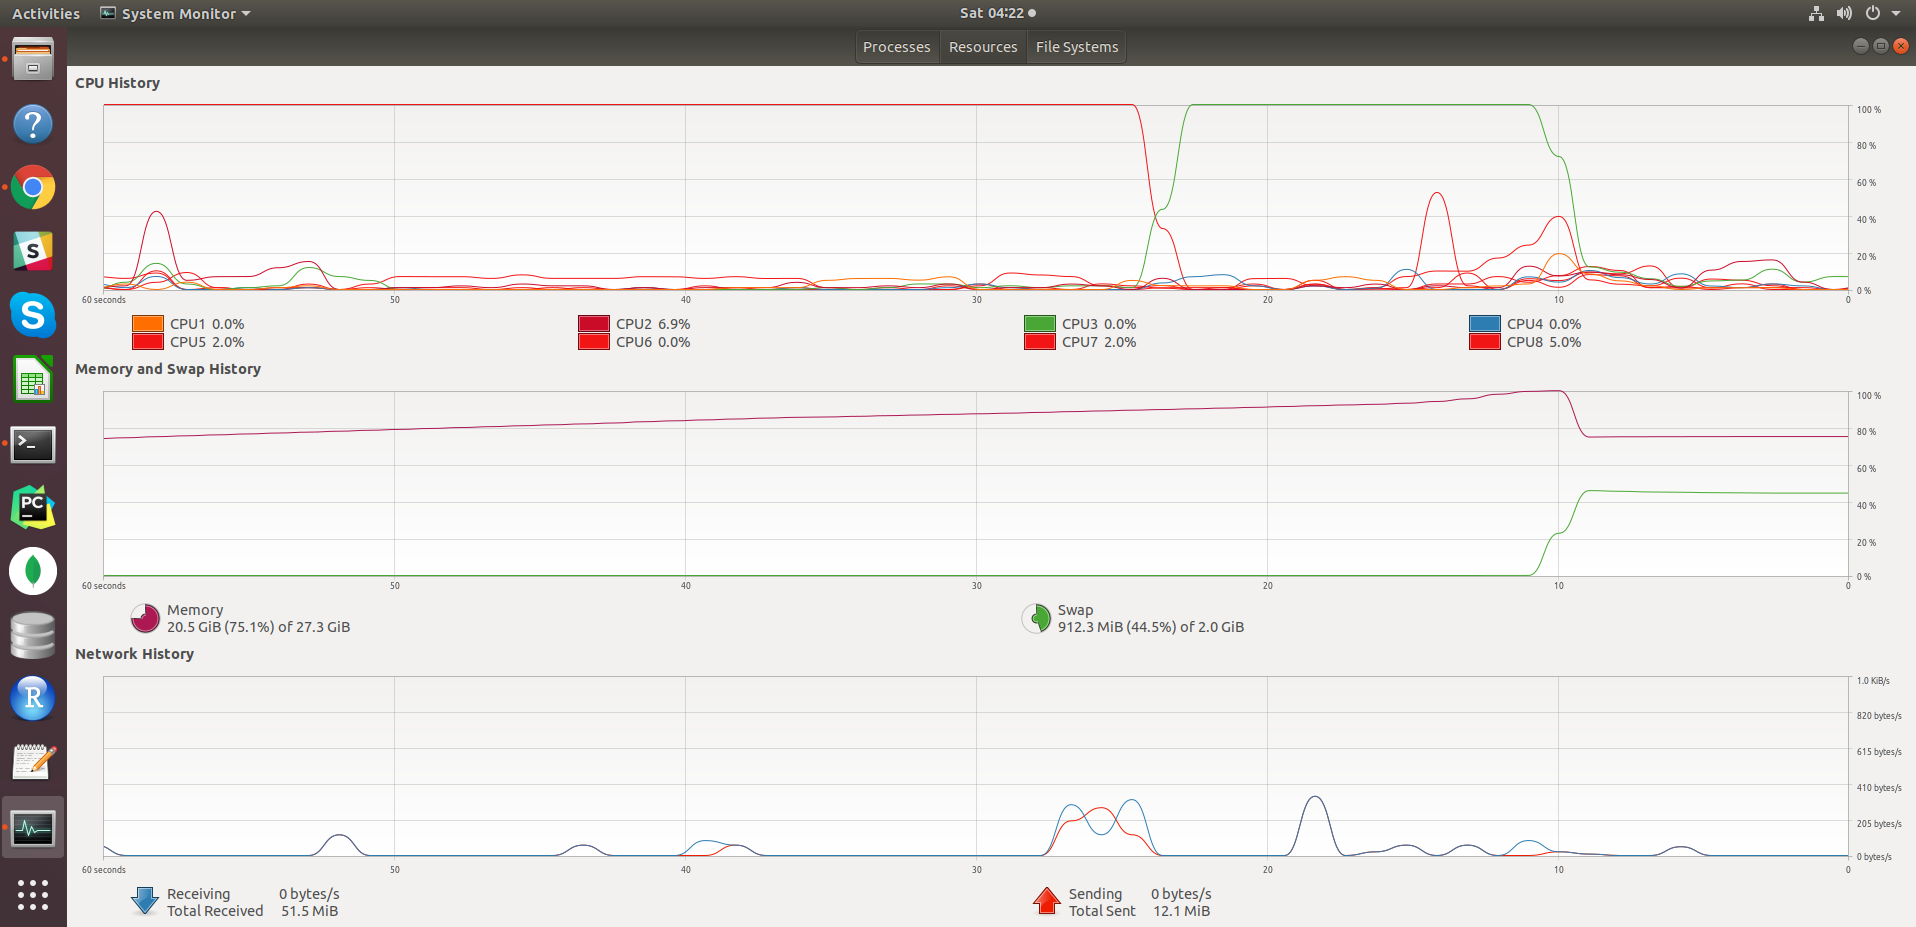

In [7]:
Image(filename = "/home/konrad/Pictures/Screenshot from 2019-01-05 04-22-31.png", width=1000, height=1000)

In [12]:
indices = pd.Series(overview_table.index, index=overview_table['title']).drop_duplicates()
indices.head(10)

title
Ariel                               0
Shadows in Paradise                 1
Four Rooms                          2
Judgment Night                      3
Life in Loops (A Megacities RMX)    4
Star Wars                           5
Finding Nemo                        6
Forrest Gump                        7
American Beauty                     8
Citizen Kane                        9
dtype: int64

In [15]:
def mrs(title, cosine_sim=cosine_sim):
    # Get the index of the movie:
    idx = indices[title]

    # Get the pairwsie similarity scores:
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies basing on similarity scores:
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores:
    sim_scores = sim_scores[0:11]

    # Movie indices:
    movie_indices = [i[0] for i in sim_scores]

    # Return top 10 most similar movies:
    return overview_table['title'].iloc[movie_indices]

In [16]:
mrs('Star Wars')

5                                                Star Wars
1260                               The Empire Strikes Back
1261                                    Return of the Jedi
45153                                         Mad Dog Time
34887                          Gigi, God's Little Princess
21876                                  The Triumph of Love
35114              Space Battleship Yamato: The New Voyage
31423                              R2-D2: Beneath the Dome
3784                                      The Crown Prince
4594     1½ Knights - In Search of the Ravishing Prince...
45609                               Islam: Empire of Faith
Name: title, dtype: object